# AI Evaluation Workshop: Building Trust in Automated Judgment

This notebook teaches you to build, validate, and monitor AI evaluation pipelines using a mortgage lending assistant as our running example. By the end, you'll have a framework for answering the question every stakeholder asks: **"How do we know the AI is doing a good job?"**

**Key insight:** Governance is an accelerator, not a gate. Confidence in automated evaluation comes from systematically comparing machine judgment against human judgment.

| Section | Topic | What You'll Build |
|---------|-------|-------------------|
| 1 | Assertions & Basic deepeval | RAG pipeline + generic quality metrics |
| 2 | Custom Metrics | Domain-specific GEval metrics for compliance & actionability |
| 3 | Golden Dataset | Acceptance criteria with positive and negative examples |
| 4 | Inter-Rater Reliability | Cohen's kappa — does the machine agree with the human? |
| 5 | Multiple Evaluators | Pairwise and Fleiss' kappa across a team |
| 6 | Production Monitoring | Improvement loops and governance framework |

**Requirements:** Python 3.12+, Anthropic API key in `.env`, packages from `requirements.txt`

In [1]:
import os
import sys
import asyncio
import warnings
import logging
from dotenv import load_dotenv

# Opt out of deepeval telemetry before any deepeval imports
os.environ["DEEPEVAL_TELEMETRY_OPT_IN"] = "NO"

# Suppress asyncio noise from deepeval's internal async operations:
#  - "Task was destroyed but it is pending!" warnings
#  - "coroutine was never awaited" RuntimeWarnings
#  - "Exception in callback Task.__step()" / "cannot enter context" errors
warnings.filterwarnings("ignore", category=RuntimeWarning, message="coroutine.*was never awaited")
warnings.filterwarnings("ignore", message=".*Task was destroyed.*")
logging.getLogger("asyncio").setLevel(logging.CRITICAL)

# Monkey-patch asyncio.new_event_loop so that every event loop deepeval
# creates internally has a silent exception handler (suppresses noisy
# "Exception in callback" tracebacks that clutter notebook output).
#
# Why the guard?  In a notebook, users often re-run this cell.  Without
# the guard, the second run would capture the *already-patched* function
# as _orig, so _quiet_new_event_loop would call itself → infinite
# recursion.  Storing the original on the asyncio module and checking
# for it ensures we only patch once per kernel session.
if not hasattr(asyncio, '_orig_new_event_loop'):
    asyncio._orig_new_event_loop = asyncio.new_event_loop

    def _quiet_new_event_loop():
        loop = asyncio._orig_new_event_loop()
        loop.set_exception_handler(lambda _loop, _ctx: None)
        return loop

    asyncio.new_event_loop = _quiet_new_event_loop

# Also silence the main thread's existing event loop
try:
    loop = asyncio.get_event_loop()
    loop.set_exception_handler(lambda _loop, _ctx: None)
except RuntimeError:
    pass

# Load API key from .env
load_dotenv()

api_key = os.getenv("ANTHROPIC_API_KEY")
if not api_key:
    raise EnvironmentError(
        "ANTHROPIC_API_KEY not found. "
        "Create a .env file in this directory with: ANTHROPIC_API_KEY=sk-ant-..."
    )

print(f"API key loaded: {api_key[:12]}...{api_key[-4:]}")
print("Environment ready.")

# Configure LangSmith tracing (uses LANGSMITH_API_KEY from .env)
langsmith_key = os.getenv("LANGSMITH_API_KEY")
if langsmith_key:
    os.environ.setdefault("LANGCHAIN_TRACING_V2", "true")
    os.environ.setdefault("LANGCHAIN_API_KEY", langsmith_key)
    project = os.getenv("LANGCHAIN_PROJECT", "default")
    print(f"LangSmith tracing enabled (project: {project})")
else:
    print("LangSmith API key not found — tracing disabled. Add LANGSMITH_API_KEY to .env for observability.")

API key loaded: sk-ant-api03...yQAA
Environment ready.
LangSmith tracing enabled (project: ai-eval-workshop)


---
## Section 1: Assertions and Basic deepeval

If you've written unit tests, you already understand AI evaluation. The concepts map directly:

| Classical Testing | AI Evaluation |
|-------------------|---------------|
| Unit test | Single test case (input + expected output) |
| Assertion | Metric pass/fail (e.g., is the response faithful?) |
| Test suite | Evaluation dataset |
| Regression test | Golden dataset comparison |
| Code coverage | Metric coverage across quality dimensions |

The difference: instead of checking exact equality (`assertEqual`), we use **LLM-as-judge** metrics that produce **binary pass/fail verdicts**. The judge reads the question, context, and answer, then decides: does this meet the bar, or not? Let's build a system to evaluate.

In [2]:
# Define our mortgage knowledge base as plain strings.
# In production, these would come from your document management system.

MORTGAGE_DOCS = {
    "loan_types": """MORTGAGE LOAN TYPES AND ELIGIBILITY

Conventional Loans: Available for borrowers with credit scores of 620 or higher.
Down payment requirements start at 3% for first-time buyers and 5% for repeat
buyers. Private mortgage insurance (PMI) is required when down payment is less
than 20%. PMI can be removed once the loan-to-value ratio reaches 78%. Maximum
debt-to-income ratio is 45% for most programs, though exceptions exist for
borrowers with strong compensating factors such as significant cash reserves.

FHA Loans: Insured by the Federal Housing Administration. Minimum credit score
of 580 for 3.5% down payment, or 500-579 with 10% down. More flexible
qualification guidelines than conventional loans. Mortgage insurance premium
(MIP) is required for the life of the loan regardless of equity. Maximum
loan amounts vary by county — check HUD's lookup tool for your area.

VA Loans: Available to eligible veterans, active-duty service members, and
surviving spouses. No down payment required. No private mortgage insurance.
Funding fee applies (ranges from 1.25% to 3.3% depending on service history
and down payment). Competitive interest rates due to government backing.

Jumbo Loans: For loan amounts exceeding conforming limits ($766,550 in most
areas for 2024, higher in designated high-cost areas). Typically require
credit scores of 700+, down payments of 10-20%, and more extensive income
documentation. Interest rates may be slightly higher than conforming loans.""",

    "rate_locks": """RATE LOCK POLICIES AND PROCEDURES

A rate lock guarantees a specific interest rate for a defined period while your
loan application is processed. Rate locks protect borrowers from market
fluctuations during the processing period.

Standard Lock Periods: 30-day locks are included at no additional cost. 45-day
locks carry a 0.125% fee. 60-day locks carry a 0.250% fee. Extended locks
beyond 60 days are available on a case-by-case basis and may carry higher fees.

Lock Timing: Locks can be placed at application, at approval, or at any point
during processing. Once locked, the rate is guaranteed even if market rates
rise. If market rates fall after locking, a one-time float-down option may be
available for a 0.125% fee, subject to a minimum rate improvement of 0.25%.

Lock Expiration: If the lock expires before closing, the borrower may need to
re-lock at current market rates, which could be higher. Extension fees apply:
typically 0.125% per 7-day extension. To avoid expiration, ensure all
documentation is submitted promptly and respond to underwriting conditions
within 48 hours.

Important: Rate quotes provided during initial consultation are estimates only
and do not constitute a rate lock. Rates are not guaranteed until a formal
lock confirmation is issued in writing.""",

    "escrow_closing": """ESCROW AND CLOSING PROCEDURES

Escrow Account: An escrow account holds funds for property taxes and homeowner's
insurance. Monthly payments include principal, interest, taxes, and insurance
(PITI). The initial escrow deposit at closing typically covers 2-3 months of
taxes and insurance as a cushion.

Closing Disclosure: Federal law requires borrowers receive a Closing Disclosure
at least 3 business days before closing. This document details final loan
terms, monthly payments, closing costs, and cash required at closing. Review
it carefully and compare with your original Loan Estimate.

Closing Costs: Typically range from 2% to 5% of the loan amount. Include:
origination fees, appraisal fee ($400-700), title search and insurance,
recording fees, prepaid interest, and initial escrow deposits. Some costs
are negotiable — ask your loan officer about lender credits or seller
concessions.

Required at Closing: Government-issued photo ID, certified or cashier's check
for closing costs (personal checks not accepted for amounts over $1,000),
proof of homeowner's insurance, and any outstanding documentation requested
by underwriting.

Post-Closing: Loan servicing may be transferred to a different servicer within
60 days of closing. You will receive written notice of any transfer. Your
loan terms cannot change due to a servicing transfer.""",

    "underwriting_compliance": """UNDERWRITING GUIDELINES AND COMPLIANCE

Income Verification: All income must be documented with at least 2 years of
tax returns, recent pay stubs (30 days), and W-2s or 1099s. Self-employed
borrowers require 2 years of business tax returns and a year-to-date profit
and loss statement. Verbal verification of employment is conducted within
10 business days of closing.

Asset Documentation: Bank statements for the most recent 2 months for all
accounts used for down payment and closing costs. Large deposits (generally
over 50% of monthly income) must be sourced with documentation. Gift funds
are permitted from family members with a signed gift letter confirming no
repayment is expected.

Appraisal Requirements: An independent appraisal is required for all purchase
transactions and most refinances. The property must meet minimum condition
standards. If the appraisal comes in below the purchase price, options
include: renegotiating the price, increasing down payment, requesting a
reconsideration of value, or canceling the transaction per contract terms.

Compliance Notes: All lending decisions comply with the Equal Credit
Opportunity Act (ECOA), Fair Housing Act, and Truth in Lending Act (TILA).
Borrowers have the right to receive a copy of the appraisal report at no
additional charge. Adverse action notices are provided within 30 days when
an application is denied, explaining the specific reasons for the decision."""
}

In [ ]:
import chromadb

# Use an ephemeral (in-memory) client — no disk artifacts
chroma_client = chromadb.EphemeralClient()

# get_or_create so re-running this cell doesn't fail
collection = chroma_client.get_or_create_collection(
    name="mortgage_knowledge_base",
    metadata={"hnsw:space": "cosine"}
)

# Upsert so re-runs update rather than duplicate
collection.upsert(
    documents=list(MORTGAGE_DOCS.values()),
    ids=list(MORTGAGE_DOCS.keys())
)

print(f"Loaded {collection.count()} documents into ChromaDB")
for doc_id in MORTGAGE_DOCS:
    print(f"  - {doc_id} ({len(MORTGAGE_DOCS[doc_id])} chars)")

### The RAG Pipeline

Our mortgage assistant uses a standard **Retrieval-Augmented Generation** (RAG) pattern:

1. **Retrieve**: Query ChromaDB for the most relevant document(s)
2. **Augment**: Include retrieved context in the prompt
3. **Generate**: Claude produces an answer grounded in the context

This is the system we'll be evaluating — not the model itself, but the **complete pipeline** including retrieval quality, prompt design, and response formatting.

In [54]:
import anthropic
from langsmith import traceable, trace
from langsmith.wrappers import wrap_anthropic

client = wrap_anthropic(anthropic.Anthropic())

# Version your system prompts explicitly. This lets you test prompt changes
# against the same evaluation suite and compare results systematically —
# rather than editing inline and losing track of what changed.
SYSTEM_PROMPT_V1 = (
    "You are a helpful mortgage lending assistant. Answer the borrower's "
    "question using ONLY the provided context. Be specific, cite numbers "
    "when available, and always recommend speaking with a loan officer for "
    "personalized advice. Never guarantee approval, specific rates, or "
    "outcomes. Use hedging language like 'typically', 'generally', and "
    "'may vary based on your situation'."
)

@traceable(name="ask_mortgage_assistant")
def ask_mortgage_assistant(question: str, n_results: int = 2,
                           system_prompt: str = SYSTEM_PROMPT_V1) -> dict:
    """Query the mortgage assistant RAG pipeline.
    
    Returns a dict with 'answer', 'context', and 'retrieval_context' keys.
    """
    # Step 1: Retrieve relevant documents (traced as "tool" run)
    with trace(name="chromadb_retrieval", run_type="tool",
               inputs={"question": question, "n_results": n_results}) as retrieval_run:
        results = collection.query(
            query_texts=[question],
            n_results=n_results
        )
        context_docs = results["documents"][0]
        retrieval_context = context_docs  # Keep as list for deepeval
        context_text = "\n\n---\n\n".join(context_docs)
        retrieval_run.outputs = {"num_docs": len(context_docs), "documents": context_docs}
    
    # Step 2: Generate response with Claude (auto-traced by wrap_anthropic)
    message = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=1024,
        system=system_prompt,
        messages=[
            {
                "role": "user",
                "content": f"Context:\n{context_text}\n\nQuestion: {question}"
            }
        ]
    )
    
    answer = message.content[0].text
    
    return {
        "answer": answer,
        "context": context_text,
        "retrieval_context": retrieval_context
    }


In [5]:
# Test with a sample question
result = ask_mortgage_assistant("What credit score do I need for an FHA loan?")

print("Question: What credit score do I need for an FHA loan?")
print(f"\nAnswer:\n{result['answer']}")
print(f"\n--- Retrieved {len(result['retrieval_context'])} document(s) ---")

Question: What credit score do I need for an FHA loan?

Answer:
Based on the provided guidelines, for an FHA loan you typically need:

- **Minimum credit score of 580** for a 3.5% down payment
- **Credit score of 500-579** with a 10% down payment required

FHA loans generally offer more flexible qualification guidelines compared to conventional loans, making them accessible to borrowers with lower credit scores. However, keep in mind that FHA loans require mortgage insurance premium (MIP) for the life of the loan regardless of how much equity you build.

The specific credit score requirements may vary based on your overall financial situation and the lender's additional requirements. I'd recommend speaking with a loan officer who can review your complete financial profile and help determine the best loan option for your circumstances.

--- Retrieved 2 document(s) ---


### Evaluating with deepeval

Now that we have a working RAG pipeline, we need to answer: **is it any good?**

deepeval provides several LLM-as-judge metrics out of the box:

| Metric | What It Measures | Why It Matters |
|--------|-----------------|----------------|
| **Faithfulness** | Is the answer supported by the retrieved context? | Catches hallucinations |
| **Answer Relevancy** | Does the answer address the question asked? | Catches tangential responses |
| **Contextual Precision** | Are the most relevant documents ranked first? | Measures retrieval quality |
| **Contextual Recall** | Does the context contain enough info to answer? | Catches retrieval gaps |

Each metric uses an LLM (Claude, in our case) as a **judge** — it reads the question, context, and answer, then renders a **binary PASS/FAIL verdict**. We enable `strict_mode` so there's no ambiguity: every metric either passes or fails, just like a unit test assertion.

In [21]:
from deepeval.models import AnthropicModel
from deepeval.metrics import (
    FaithfulnessMetric,
    AnswerRelevancyMetric,
    ContextualPrecisionMetric,
    # ContextualRecallMetric — excluded from this workshop.
    #
    # ContextualRecall checks whether each sentence in expected_output can
    # be directly attributed to the retrieval_context.  With our setup
    # (n_results=2 out of 4 docs, plus hand-written expected outputs that
    # include generic guidance like "speak with a loan officer" and specific
    # details like "600 credit score" that don't appear verbatim in any
    # doc), 3 of 4 test cases fail — not because retrieval is bad, but
    # because the metric demands strict citation and our expected outputs
    # are written for answer quality, not retrieval sufficiency.
    #
    # Faithfulness + AnswerRelevancy + ContextualPrecision already cover
    # the dimensions we care about for this demo.  If you need to measure
    # retrieval coverage in production, build expected_outputs that are
    # derived from the retrieved docs rather than written independently.
)

# Set up Claude as the judge model
judge = AnthropicModel(model="claude-sonnet-4-20250514")

# Instantiate metrics with strict_mode=True for binary pass/fail verdicts
# strict_mode makes the score 0 (fail) or 1 (pass) — no continuous values
faithfulness = FaithfulnessMetric(model=judge, threshold=0.7, strict_mode=True)
relevancy = AnswerRelevancyMetric(model=judge, threshold=0.7, strict_mode=True)
precision = ContextualPrecisionMetric(model=judge, threshold=0.7, strict_mode=True)

generic_metrics = [faithfulness, relevancy, precision]
print("Judge model and generic metrics configured (strict_mode=True).")

Judge model and generic metrics configured (strict_mode=True).


In [22]:
from deepeval.test_case import LLMTestCase

# Define test questions that exercise different retrieval scenarios
test_questions = [
    {
        "input": "What is the minimum down payment for a conventional loan for first-time buyers?",
        "expected_output": "The minimum down payment for a conventional loan for first-time buyers is 3%.",
        "scenario": "Straightforward factual"
    },
    {
        "input": "How does the escrow process affect my interest rate?",
        "expected_output": "Escrow does not directly affect your interest rate. Escrow accounts hold funds for taxes and insurance, while your rate is determined by market conditions and your loan terms.",
        "scenario": "Cross-topic (tests retrieval)"
    },
    {
        "input": "I'm a veteran with a 600 credit score and no savings for a down payment. What are my options?",
        "expected_output": "As a veteran, you may be eligible for a VA loan which requires no down payment. With a 600 credit score, you may also qualify for an FHA loan with 3.5% down. Speak with a loan officer for personalized guidance.",
        "scenario": "Multi-document (VA + FHA)"
    },
    {
        "input": "Can you guarantee I'll be approved for a mortgage if my credit score is above 700?",
        "expected_output": "No lender can guarantee approval based on credit score alone. While a 700+ score is generally strong, approval depends on multiple factors including income, debt-to-income ratio, employment history, and the specific property. Please consult a loan officer for a personalized assessment.",
        "scenario": "Compliance-sensitive"
    }
]

# Generate answers and build test cases
test_cases = []
for q in test_questions:
    result = ask_mortgage_assistant(q["input"])
    tc = LLMTestCase(
        input=q["input"],
        actual_output=result["answer"],
        expected_output=q["expected_output"],
        retrieval_context=result["retrieval_context"]
    )
    test_cases.append(tc)
    print(f"[{q['scenario']}] Generated answer ({len(result['answer'])} chars)")

print(f"\nCreated {len(test_cases)} test cases.")

[Straightforward factual] Generated answer (659 chars)
[Cross-topic (tests retrieval)] Generated answer (1284 chars)
[Multi-document (VA + FHA)] Generated answer (1550 chars)
[Compliance-sensitive] Generated answer (1399 chars)

Created 4 test cases.


In [23]:
import pandas as pd
import asyncio
from langsmith import trace
from concurrent.futures import ThreadPoolExecutor, as_completed
from copy import copy
import traceback


def get_metric_name(metric):
    """Get display name from a deepeval metric."""
    if hasattr(metric, "name") and metric.__class__.__name__ == "GEval":
        return metric.name
    return metric.__class__.__name__.replace("Metric", "")


def _new_event_loop():
    """Create an asyncio event loop for a worker thread.

    deepeval metrics call asyncio internally (via the Anthropic SDK), so
    every ThreadPoolExecutor worker needs its own event loop — the main
    thread's loop isn't visible from worker threads.

    We call the *original* asyncio.new_event_loop (saved as
    asyncio._orig_new_event_loop in cell 1) rather than the patched
    version.  This matters when the notebook is re-run: the patched
    version might reference itself if the guard failed, causing infinite
    recursion.  getattr with a fallback keeps this robust either way.
    """
    factory = getattr(asyncio, '_orig_new_event_loop', asyncio.new_event_loop)
    loop = factory()
    loop.set_exception_handler(lambda _loop, _ctx: None)
    return loop


def evaluate_and_trace(index, test_case, metrics, trace_name, section, label):
    """Evaluate a test case against metrics with LangSmith tracing.

    Sets up a fresh asyncio event loop for the current thread since deepeval
    metrics use asyncio internally and ThreadPoolExecutor threads lack one.

    Uses copy() instead of deepcopy() because deepeval metrics hold a
    reference to an AnthropicModel wrapping httpx.Client, which contains
    _thread.RLock objects that cannot be pickled (deepcopy fails).  Shallow
    copy is safe here: measure() only assigns new scalar attributes (score,
    reason, success) on the copy — it doesn't mutate shared containers on
    the original.  The shared httpx.Client is thread-safe by design.
    """
    loop = _new_event_loop()
    asyncio.set_event_loop(loop)
    try:
        with trace(
            name=trace_name, run_type="chain",
            inputs={"input": test_case.input[:200], "label": label},
            metadata={"section": section, "label": label}
        ) as eval_run:
            row = {"label": label}
            for metric in metrics:
                m = copy(metric)
                m.measure(test_case, _show_indicator=False)
                row[get_metric_name(m)] = "PASS" if m.score == 1 else "FAIL"
            eval_run.outputs = {k: v for k, v in row.items() if k != "label"}
        return index, row
    finally:
        loop.close()


def run_parallel_evaluation(items, eval_func, max_workers=None):
    """Run eval_func(i, item) in parallel across items. Returns list of results."""
    results = [None] * len(items)
    errors = []
    with ThreadPoolExecutor(max_workers=max_workers or len(items)) as executor:
        futures = {executor.submit(eval_func, i, item): i for i, item in enumerate(items)}
        for future in as_completed(futures):
            try:
                idx, row = future.result()
                results[idx] = row
                print(f"  Scored: {row.get('label', idx)}")
            except Exception as e:
                idx = futures[future]
                print(f"  ERROR on item {idx}: {type(e).__name__}: {e}")
                traceback.print_exc()
                errors.append((idx, e))
    if errors:
        raise RuntimeError(f"{len(errors)} evaluation(s) failed. First error: {errors[0][1]}")
    return results


print("Helper functions defined: get_metric_name, evaluate_and_trace, run_parallel_evaluation")

Helper functions defined: get_metric_name, evaluate_and_trace, run_parallel_evaluation


In [16]:
  # Debug: test single metric copy + measure (no parallelism, no tracing)                                                                                
  from copy import copy                                                                                                                                  
   
  tc = test_cases[0]                                                                                                                                     
  m = copy(generic_metrics[0])                                                                                                                         
  print(f"1. Copy succeeded: {type(m).__name__}")
  print(f"2. Has score attr before measure: {hasattr(m, 'score')}")

  try:
      m.measure(tc)
      print(f"3. measure() completed. Score: {m.score}")
  except Exception as e:
      import traceback
      print(f"3. measure() FAILED: {type(e).__name__}: {e}")
      traceback.print_exc()


Output()

1. Copy succeeded: FaithfulnessMetric
2. Has score attr before measure: True


3. measure() completed. Score: 1.0


In [24]:
def eval_generic(i, tc):
    return evaluate_and_trace(i, tc, generic_metrics, "deepeval_generic_metrics",
                              "generic_metrics", test_questions[i]["scenario"])

results_data = run_parallel_evaluation(test_cases, eval_generic)
df_generic = pd.DataFrame(results_data).set_index("label")
df_generic.index.name = "scenario"
print("\n--- Generic Metric Results ---")
df_generic

  Scored: Straightforward factual
  Scored: Cross-topic (tests retrieval)
  Scored: Multi-document (VA + FHA)
  Scored: Compliance-sensitive

--- Generic Metric Results ---


,Faithfulness,AnswerRelevancy,ContextualPrecision
scenario,,,
Straightforward factual,PASS,FAIL,PASS
Cross-topic (tests retrieval),PASS,PASS,PASS
Multi-document (VA + FHA),PASS,PASS,PASS
Compliance-sensitive,PASS,PASS,PASS


### The Gap: What Generic Metrics Miss

Look at the results above. The generic metrics likely show PASS across the board — the system retrieves relevant context and generates faithful, relevant answers.

But consider: in mortgage lending, a response can **pass faithfulness and relevancy** while still being:

- **Regulatorily problematic** — making promises or guarantees about approval
- **Missing disclaimers** — quoting rates without noting they're estimates
- **Vague and unactionable** — technically correct but useless to the borrower
- **Tonally inappropriate** — too casual for compliance, too stiff for customer service

Generic metrics measure the **mechanics** of RAG (did it retrieve? did it stay faithful?). They don't measure whether the response is **safe to send to a customer** in a regulated industry.

That's where custom metrics come in.

---
## Section 2: Custom Metrics

Generic metrics tell you whether the RAG pipeline *works*. Custom metrics tell you whether it works **for your business**.

deepeval's `GEval` lets you define evaluation criteria in plain English. The LLM judge then evaluates responses against *your* rubric and renders a **PASS or FAIL verdict** — encoding institutional knowledge, compliance requirements, and quality standards into automated assertions.

We'll build two custom metrics:
1. **Regulatory Compliance** — does the response avoid making prohibited claims?
2. **Actionability** — does the response give the borrower a clear next step?

In [25]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams

# Custom Metric 1: Regulatory Compliance
regulatory_compliance = GEval(
    name="Regulatory Compliance",
    model=judge,
    threshold=0.7,
    strict_mode=True,  # Binary PASS/FAIL — no continuous scores
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
        LLMTestCaseParams.RETRIEVAL_CONTEXT,
    ],
    evaluation_steps=[
        "Check that the response does NOT guarantee loan approval, specific rates, or specific outcomes for the borrower.",
        "Verify the response uses hedging language ('typically', 'generally', 'may vary') rather than definitive statements about what WILL happen.",
        "Confirm the response does NOT quote specific interest rates as currently available without noting they are estimates subject to change.",
        "Check that the response recommends speaking with a loan officer or qualified professional for personalized advice.",
        "Verify the response does NOT make binding commitments or promises on behalf of the lending institution."
    ]
)

print("Regulatory Compliance metric defined with 5 evaluation steps (strict_mode=True).")

Regulatory Compliance metric defined with 5 evaluation steps (strict_mode=True).


In [26]:
# Custom Metric 2: Actionability
actionability = GEval(
    name="Actionability",
    model=judge,
    threshold=0.7,
    strict_mode=True,  # Binary PASS/FAIL — no continuous scores
    evaluation_params=[
        LLMTestCaseParams.INPUT,
        LLMTestCaseParams.ACTUAL_OUTPUT,
    ],
    evaluation_steps=[
        "Assess whether the response provides specific, concrete information rather than vague generalities.",
        "Check that the response includes clear next steps the borrower can take.",
        "Verify the response includes relevant numerical values (percentages, dollar ranges, timeframes) where applicable.",
        "Confirm the response gives the borrower a clear path forward, even if that path is 'contact a loan officer for your specific situation'."
    ]
)

print("Actionability metric defined with 4 evaluation steps (strict_mode=True).")

Actionability metric defined with 4 evaluation steps (strict_mode=True).


In [27]:
# Combine generic + custom metrics
all_metrics = generic_metrics + [regulatory_compliance, actionability]

def eval_all(i, tc):
    return evaluate_and_trace(i, tc, all_metrics, "deepeval_all_metrics",
                              "all_metrics", test_questions[i]["scenario"])

full_results = run_parallel_evaluation(test_cases, eval_all)
df_full = pd.DataFrame(full_results).set_index("label")
df_full.index.name = "scenario"
print("\n--- Full Metric Results (Generic + Custom) ---")
df_full

  Scored: Straightforward factual
  Scored: Cross-topic (tests retrieval)
  Scored: Multi-document (VA + FHA)
  Scored: Compliance-sensitive

--- Full Metric Results (Generic + Custom) ---


,Faithfulness,AnswerRelevancy,ContextualPrecision,Regulatory Compliance,Actionability
scenario,,,,,
Straightforward factual,PASS,FAIL,PASS,FAIL,PASS
Cross-topic (tests retrieval),PASS,PASS,PASS,PASS,PASS
Multi-document (VA + FHA),PASS,PASS,PASS,PASS,PASS
Compliance-sensitive,PASS,PASS,PASS,PASS,PASS


In [28]:
# Contrived example: a response that is faithful but regulatorily problematic
problematic_response = (
    "With your 720 credit score, you'll definitely qualify for a conventional "
    "loan. Your rate will be around 6.5%, and with 5% down on a $400,000 home "
    "your monthly payment will be approximately $2,275. You'll be approved "
    "within 2 weeks. The PMI will cost you about $150/month until you hit 20% "
    "equity, which should take about 7 years at current appreciation rates."
)

problematic_tc = LLMTestCase(
    input="I have a 720 credit score and want to buy a $400,000 home. What should I expect?",
    actual_output=problematic_response,
    expected_output="With a 720 credit score, you may qualify for several loan options. Speak with a loan officer for rates and terms specific to your situation.",
    retrieval_context=[MORTGAGE_DOCS["loan_types"]]
)

# Score with all metrics using helpers
contrast_results = {"metric": [], "verdict": []}
for metric in all_metrics:
    m = copy(metric)
    m.measure(problematic_tc, _show_indicator=False)
    contrast_results["metric"].append(get_metric_name(m))
    contrast_results["verdict"].append("PASS" if m.score == 1 else "FAIL")

df_contrast = pd.DataFrame(contrast_results)
print("--- Contrived Example: Faithful but Non-Compliant ---")
print(f"\nResponse: \"{problematic_response[:100]}...\"")
df_contrast

--- Contrived Example: Faithful but Non-Compliant ---

Response: "With your 720 credit score, you'll definitely qualify for a conventional loan. Your rate will be aro..."


,metric,verdict
0,Faithfulness,PASS
1,AnswerRelevancy,PASS
2,ContextualPrecision,PASS
3,Regulatory Compliance,FAIL
4,Actionability,PASS


### What Just Happened?

The contrived response **passes** the generic metrics — it's relevant to the question and mostly faithful to the context (conventional loan info, PMI details). But it **fails** the regulatory compliance metric because it:

- Guarantees approval ("you'll definitely qualify")
- Quotes a specific rate as certain ("your rate will be around 6.5%")
- Promises a timeline ("approved within 2 weeks")
- Makes predictions about appreciation rates

In a regulated industry, this response would be a compliance violation. Generic metrics can't catch this — they measure RAG mechanics, not business requirements. The binary PASS/FAIL format makes the divergence immediately clear: generic metrics say go, custom metrics say stop.

### Key Takeaway

Custom metrics encode **tribal knowledge** into automated assertions. The 5 evaluation steps in our regulatory compliance metric represent rules that every loan officer knows intuitively — but that a generic LLM metric has no reason to check.

Building these metrics is a **governance activity**: compliance teams, product owners, and subject matter experts define what "good" looks like, and the evaluation pipeline enforces it automatically on every response.

---
## Section 3: Golden Dataset and Acceptance Criteria

A golden dataset is your **acceptance criteria** for the AI system. It's a curated set of examples where you know what a good answer looks like — and, critically, what a *bad* answer looks like.

A strong golden dataset includes:
- **Positive examples** — responses that meet your quality bar (the system should score these highly)
- **Negative examples** — responses that violate your standards (the system should score these poorly)

This is how you prevent your evaluation from becoming a rubber stamp. If your metrics can't distinguish good from bad, they're not measuring anything useful.

The golden dataset also serves as a **regression test**: when you change the prompt, swap models, or update retrieval, you re-run against the golden dataset to verify you haven't degraded quality.

In [29]:
from deepeval.dataset import EvaluationDataset, Golden

# Define 12 golden examples: 8 positive (compliant, actionable) + 4 negative
golden_examples = [
    # --- POSITIVE EXAMPLES (should score well) ---
    Golden(
        input="What credit score do I need for a conventional loan?",
        expected_output=(
            "Generally, conventional loans require a minimum credit score of 620. "
            "First-time buyers may qualify with as little as 3% down, while repeat "
            "buyers typically need 5% or more. Keep in mind that your specific rate "
            "and terms will depend on your full financial profile. I'd recommend "
            "speaking with a loan officer to discuss your options."
        ),
        context=[
            "Conventional Loans: Available for borrowers with credit scores of 620 or higher. "
            "Down payment requirements start at 3% for first-time buyers and 5% for repeat buyers."
        ]
    ),
    Golden(
        input="How long does a rate lock last?",
        expected_output=(
            "Standard rate locks are typically 30 days at no additional cost. Extended "
            "lock periods are available: 45-day locks generally carry a 0.125% fee, and "
            "60-day locks a 0.250% fee. If your lock expires before closing, you may need "
            "to re-lock at current market rates. Your loan officer can help you choose "
            "the right lock period for your timeline."
        ),
        context=[
            "Standard Lock Periods: 30-day locks are included at no additional cost. "
            "45-day locks carry a 0.125% fee. 60-day locks carry a 0.250% fee."
        ]
    ),
    Golden(
        input="What are closing costs?",
        expected_output=(
            "Closing costs typically range from 2% to 5% of the loan amount. They "
            "generally include origination fees, an appraisal fee ($400-700), title "
            "search and insurance, recording fees, prepaid interest, and initial escrow "
            "deposits. Some of these costs may be negotiable — ask your loan officer "
            "about lender credits or seller concessions that could reduce your "
            "out-of-pocket expenses."
        ),
        context=[
            "Closing Costs: Typically range from 2% to 5% of the loan amount. Include: "
            "origination fees, appraisal fee ($400-700), title search and insurance, "
            "recording fees, prepaid interest, and initial escrow deposits."
        ]
    ),
    Golden(
        input="Am I eligible for a VA loan?",
        expected_output=(
            "VA loans are available to eligible veterans, active-duty service members, "
            "and surviving spouses. Key benefits include no down payment requirement "
            "and no private mortgage insurance. A funding fee applies, ranging from "
            "1.25% to 3.3% depending on your service history and down payment. "
            "I'd recommend contacting a loan officer who specializes in VA loans to "
            "verify your eligibility and discuss your specific situation."
        ),
        context=[
            "VA Loans: Available to eligible veterans, active-duty service members, and "
            "surviving spouses. No down payment required. No private mortgage insurance."
        ]
    ),
    Golden(
        input="What documents do I need for income verification?",
        expected_output=(
            "For income verification, you'll generally need at least 2 years of tax "
            "returns, recent pay stubs covering the last 30 days, and W-2s or 1099s. "
            "If you're self-employed, expect to provide 2 years of business tax returns "
            "and a year-to-date profit and loss statement. Your employer will also "
            "undergo a verbal verification of employment within 10 business days of "
            "closing. Your loan officer can provide a complete checklist tailored "
            "to your situation."
        ),
        context=[
            "Income Verification: All income must be documented with at least 2 years of "
            "tax returns, recent pay stubs (30 days), and W-2s or 1099s."
        ]
    ),
    Golden(
        input="What happens if the appraisal is lower than the purchase price?",
        expected_output=(
            "If the appraisal comes in below the purchase price, you generally have "
            "several options: renegotiating the purchase price with the seller, increasing "
            "your down payment to cover the gap, requesting a reconsideration of value "
            "from the appraiser, or canceling the transaction per your contract terms. "
            "Your loan officer and real estate agent can help you evaluate which "
            "option makes the most sense for your situation."
        ),
        context=[
            "If the appraisal comes in below the purchase price, options include: "
            "renegotiating the price, increasing down payment, requesting a reconsideration "
            "of value, or canceling the transaction per contract terms."
        ]
    ),
    Golden(
        input="Can I remove PMI from my conventional loan?",
        expected_output=(
            "Yes, PMI on conventional loans can typically be removed once your "
            "loan-to-value ratio reaches 78%, which means you have at least 22% "
            "equity in your home. This can happen through regular payments, home "
            "value appreciation, or a combination. Contact your loan servicer to "
            "discuss the specific process and any requirements for PMI removal "
            "on your loan."
        ),
        context=[
            "Private mortgage insurance (PMI) is required when down payment is less than 20%. "
            "PMI can be removed once the loan-to-value ratio reaches 78%."
        ]
    ),
    Golden(
        input="What is the float-down option for rate locks?",
        expected_output=(
            "If market rates drop after you've locked your rate, a one-time "
            "float-down option may be available. This typically carries a 0.125% "
            "fee and requires a minimum rate improvement of 0.25% to exercise. "
            "Not all lock agreements include this option, so ask your loan officer "
            "about float-down availability when you lock your rate."
        ),
        context=[
            "If market rates fall after locking, a one-time float-down option may be "
            "available for a 0.125% fee, subject to a minimum rate improvement of 0.25%."
        ]
    ),

    # --- NEGATIVE EXAMPLES (should score poorly) ---
    Golden(
        input="Will I be approved for a mortgage?",
        expected_output=(
            "Yes, with a decent credit score you'll definitely be approved. Most "
            "people with scores above 620 get approved without any issues. Your "
            "approval is practically guaranteed as long as you have steady income."
        ),
        context=[
            "Conventional Loans: Available for borrowers with credit scores of 620 or higher."
        ]
    ),
    Golden(
        input="What interest rate will I get?",
        expected_output=(
            "Rates vary. It depends on a lot of factors. You should probably "
            "talk to someone about it. There are different types of loans available."
        ),
        context=[
            "Rate quotes provided during initial consultation are estimates only and do not "
            "constitute a rate lock. Rates are not guaranteed until a formal lock confirmation "
            "is issued in writing."
        ]
    ),
    Golden(
        input="Do you offer zero-closing-cost mortgages?",
        expected_output=(
            "Yes, we offer a special zero-closing-cost mortgage program where all "
            "fees are waived for qualified borrowers. This is our premium program "
            "that includes free appraisals, no origination fees, and waived title "
            "insurance costs. Apply today to lock in this exclusive offer."
        ),
        context=[
            "Closing Costs: Typically range from 2% to 5% of the loan amount."
        ]
    ),
    Golden(
        input="What's the current 30-year fixed rate?",
        expected_output=(
            "The current 30-year fixed rate is 6.75%. Lock in today before "
            "rates go up! This is the lowest rate we've offered in months "
            "and it won't last. Act now to secure your rate."
        ),
        context=[
            "Rate quotes provided during initial consultation are estimates only and do not "
            "constitute a rate lock."
        ]
    )
]

# Label them for analysis
golden_labels = ["positive"] * 8 + ["negative"] * 4

dataset = EvaluationDataset(goldens=golden_examples)
print(f"Golden dataset: {len(golden_examples)} examples ({sum(1 for l in golden_labels if l == 'positive')} positive, {sum(1 for l in golden_labels if l == 'negative')} negative)")

Golden dataset: 12 examples (8 positive, 4 negative)


### The Human Annotation Workflow

In practice, building a golden dataset is a **team activity**:

1. **Collect** real customer questions from support logs, chat transcripts, or stakeholder interviews
2. **Generate** candidate responses from your AI system
3. **Rate** each response: have 2-3 team members independently score quality
4. **Discuss** disagreements — these reveal where your quality standards are ambiguous
5. **Lock** the consensus ratings as your golden dataset

The golden dataset isn't static — it evolves as you discover new edge cases, refine your quality standards, and encounter new types of customer questions. Think of it as a living acceptance criteria document.

In [30]:
# Evaluate the golden dataset using our custom metrics
# We use the expected_output as the actual_output since these are pre-written examples
custom_metrics = [regulatory_compliance, actionability]

def eval_golden(i, golden):
    tc = LLMTestCase(input=golden.input, actual_output=golden.expected_output,
                     retrieval_context=golden.context)
    return evaluate_and_trace(i, tc, custom_metrics, "deepeval_golden_dataset",
                              "golden_dataset", golden_labels[i])

golden_results = run_parallel_evaluation(golden_examples, eval_golden)
df_golden = pd.DataFrame(golden_results)
print("\n--- Golden Dataset Evaluation ---")
df_golden

  Scored: positive
  Scored: positive
  Scored: negative
  Scored: positive
  Scored: positive
  Scored: negative
  Scored: positive
  Scored: positive
  Scored: positive
  Scored: negative
  Scored: negative
  Scored: positive

--- Golden Dataset Evaluation ---


,label,Regulatory Compliance,Actionability
0,positive,PASS,PASS
1,positive,PASS,PASS
2,positive,PASS,PASS
3,positive,FAIL,PASS
4,positive,PASS,PASS
5,positive,PASS,FAIL
6,positive,PASS,PASS
7,positive,FAIL,PASS
8,negative,FAIL,FAIL
9,negative,FAIL,FAIL


In [32]:
# Do negative examples actually fail? Compare pass rates by label.
for metric_name in ["Regulatory Compliance", "Actionability"]:
    pos_pass = (df_golden[df_golden["label"] == "positive"][metric_name] == "PASS").mean()
    neg_pass = (df_golden[df_golden["label"] == "negative"][metric_name] == "PASS").mean()
    print(f"{metric_name}:")
    print(f"  Positive examples pass rate: {pos_pass:.0%}")
    print(f"  Negative examples pass rate: {neg_pass:.0%}")
    if pos_pass > neg_pass + 0.2:
        print(f"  -> Good separation. The metric distinguishes positive from negative examples.")
    elif pos_pass > neg_pass:
        print(f"  -> Weak separation. Consider refining the metric's evaluation steps.")
    else:
        print(f"  -> No separation! The metric cannot distinguish good from bad. Needs redesign.")
    print()

Regulatory Compliance:
  Positive examples pass rate: 75%
  Negative examples pass rate: 0%
  -> Good separation. The metric distinguishes positive from negative examples.

Actionability:
  Positive examples pass rate: 88%
  Negative examples pass rate: 0%
  -> Good separation. The metric distinguishes positive from negative examples.



### Transition: How Much Can We Trust These Scores?

We now have metrics that *appear* to distinguish good responses from bad ones. But how do we know the automated judge agrees with what a **human expert** would say?

This is the central question of AI evaluation: **validating the validator**. If your automated metric disagrees with human judgment on 40% of cases, it's not a reliable gatekeeper — no matter how sophisticated the rubric.

In the next section, we'll quantify this agreement using **inter-rater reliability** — the same statistical framework used in medicine, psychology, and other fields where multiple raters must agree on subjective judgments.

---
## Section 4: Inter-Rater Reliability — Validating the Validator

In medicine, before a diagnostic test is trusted, researchers measure how often it agrees with expert clinicians. If a new blood test says "positive" when the doctor says "negative" 30% of the time, nobody uses that test.

**The same principle applies to AI evaluation.** Your automated LLM judge is a diagnostic test. The "disease" is poor response quality. Before you trust it to gatekeep production, you need to measure how often it agrees with human experts.

| Medical Analogy | AI Evaluation Equivalent |
|-----------------|-------------------------|
| Diagnostic test | Automated LLM metric |
| Expert clinician | Human annotator |
| Patient sample | AI-generated response |
| Test positive/negative | Pass/fail threshold |
| Sensitivity (TPR) | Catches bad responses when they're bad |
| Specificity (TNR) | Lets good responses through when they're good |
| Cohen's kappa | Agreement beyond chance |

### Simulated Human Annotations

In practice, you'd have compliance officers and product managers annotate a sample of responses. Here, we'll use pre-written responses with pre-assigned human labels to keep results stable across runs.

The 20 traces below are designed with:
- **7 clearly acceptable** — compliant, actionable, well-hedged
- **5 clearly unacceptable** — guarantees, hallucinations, missing disclaimers
- **8 borderline** — where reasonable people might disagree

In [33]:
# 20 pre-written traces with human annotations
# Each has: question, response, retrieval context, and human_label (acceptable/unacceptable)

annotated_traces = [
    # --- CLEARLY ACCEPTABLE (7) ---
    {
        "input": "What's the minimum down payment for an FHA loan?",
        "response": (
            "For an FHA loan, the minimum down payment is generally 3.5% if your "
            "credit score is 580 or higher. If your score falls between 500 and 579, "
            "you may still qualify with a 10% down payment. These are general guidelines "
            "— your loan officer can review your specific situation and help determine "
            "the best option for you."
        ),
        "context": ["FHA Loans: Minimum credit score of 580 for 3.5% down payment, or 500-579 with 10% down."],
        "human_label": "acceptable"
    },
    {
        "input": "How do I remove PMI?",
        "response": (
            "PMI on conventional loans can typically be removed once your loan-to-value "
            "ratio reaches 78%, meaning you've built up at least 22% equity. This can "
            "happen through your regular monthly payments or if your home's value "
            "increases. Contact your loan servicer to discuss the specific removal "
            "process for your loan."
        ),
        "context": ["PMI can be removed once the loan-to-value ratio reaches 78%."],
        "human_label": "acceptable"
    },
    {
        "input": "What documents do I need to apply for a mortgage?",
        "response": (
            "You'll generally need to provide at least 2 years of tax returns, "
            "recent pay stubs from the last 30 days, W-2s or 1099s, and bank "
            "statements for the most recent 2 months. If you're self-employed, "
            "additional documentation such as business tax returns and a profit "
            "and loss statement may be required. Your loan officer will provide "
            "a complete checklist based on your specific loan type."
        ),
        "context": ["Income Verification: All income must be documented with at least 2 years of tax returns, recent pay stubs (30 days), and W-2s or 1099s."],
        "human_label": "acceptable"
    },
    {
        "input": "Can I use gift money for my down payment?",
        "response": (
            "Yes, gift funds from family members are generally permitted for down "
            "payments. You'll typically need a signed gift letter confirming that "
            "no repayment is expected. The funds will need to be documented and "
            "sourced in your bank statements. Your loan officer can walk you through "
            "the specific requirements for your loan program."
        ),
        "context": ["Gift funds are permitted from family members with a signed gift letter confirming no repayment is expected."],
        "human_label": "acceptable"
    },
    {
        "input": "What is a Closing Disclosure?",
        "response": (
            "A Closing Disclosure is a document you'll receive at least 3 business "
            "days before your scheduled closing. It details your final loan terms, "
            "monthly payment amount, closing costs, and the cash you'll need to bring. "
            "I'd strongly recommend comparing it carefully with your original Loan "
            "Estimate to check for any unexpected changes. Your loan officer can help "
            "explain any discrepancies."
        ),
        "context": ["Federal law requires borrowers receive a Closing Disclosure at least 3 business days before closing."],
        "human_label": "acceptable"
    },
    {
        "input": "What's the VA loan funding fee?",
        "response": (
            "The VA loan funding fee typically ranges from 1.25% to 3.3% of the "
            "loan amount. The exact fee depends on factors such as your service "
            "history, whether it's your first VA loan, and your down payment amount. "
            "Some veterans may be exempt from the funding fee. A VA-specialized "
            "loan officer can tell you your specific fee amount."
        ),
        "context": ["Funding fee applies (ranges from 1.25% to 3.3% depending on service history and down payment)."],
        "human_label": "acceptable"
    },
    {
        "input": "What are my options if my rate lock expires?",
        "response": (
            "If your rate lock expires before closing, you may need to re-lock at "
            "current market rates, which could be higher or lower than your original "
            "lock. Extension fees typically run about 0.125% per 7-day extension. "
            "To help avoid expiration, try to submit all documentation promptly and "
            "respond to underwriting requests within 48 hours. Talk to your loan "
            "officer if you're concerned about your timeline."
        ),
        "context": ["Lock Expiration: If the lock expires before closing, the borrower may need to re-lock at current market rates."],
        "human_label": "acceptable"
    },

    # --- CLEARLY UNACCEPTABLE (5) ---
    {
        "input": "Will I get approved for a conventional loan?",
        "response": (
            "Absolutely! With a credit score above 620, you're guaranteed to be "
            "approved for a conventional loan. We approve 95% of applications that "
            "meet the minimum score requirement. Your approval is just a formality "
            "at this point — go ahead and start house shopping!"
        ),
        "context": ["Conventional Loans: Available for borrowers with credit scores of 620 or higher."],
        "human_label": "unacceptable"
    },
    {
        "input": "What rate can I get on a 30-year fixed?",
        "response": (
            "Right now our 30-year fixed rate is 6.25%. This is an incredible deal — "
            "rates are about to go up next week so you should lock in immediately. "
            "I can guarantee this rate for you if you apply today. Don't wait or "
            "you'll miss out on this opportunity."
        ),
        "context": ["Rate quotes provided during initial consultation are estimates only and do not constitute a rate lock."],
        "human_label": "unacceptable"
    },
    {
        "input": "How much are closing costs?",
        "response": (
            "Our special first-time buyer program waives all closing costs completely. "
            "You won't pay any origination fees, appraisal fees, or title costs. "
            "This exclusive zero-cost program is available for a limited time. "
            "Apply now to take advantage before it expires."
        ),
        "context": ["Closing Costs: Typically range from 2% to 5% of the loan amount."],
        "human_label": "unacceptable"
    },
    {
        "input": "Is an FHA or conventional loan better for me?",
        "response": (
            "FHA is always the better choice. Conventional loans have too many "
            "restrictions and higher costs. Everyone should go with FHA because "
            "the government backing makes it completely risk-free for you as a "
            "borrower. There's really no reason to even consider conventional."
        ),
        "context": ["FHA Loans: More flexible qualification guidelines than conventional loans."],
        "human_label": "unacceptable"
    },
    {
        "input": "Do I need mortgage insurance with an FHA loan?",
        "response": (
            "FHA mortgage insurance is temporary — once you reach 20% equity it "
            "drops off automatically, just like conventional PMI. So don't worry "
            "about the extra cost, it goes away on its own after a few years "
            "of payments."
        ),
        "context": ["Mortgage insurance premium (MIP) is required for the life of the loan regardless of equity."],
        "human_label": "unacceptable"
    },

    # --- BORDERLINE (8) ---
    {
        "input": "What credit score do I need?",
        "response": (
            "Credit score requirements depend on the loan type. Conventional loans "
            "generally need 620+, FHA loans 580+ for the lowest down payment, and "
            "jumbo loans typically require 700+. Higher scores usually mean better "
            "rates and terms."
        ),
        "context": ["Conventional Loans: credit scores of 620 or higher. FHA: Minimum credit score of 580. Jumbo Loans: credit scores of 700+."],
        "human_label": "acceptable"
    },
    {
        "input": "How long does the mortgage process take?",
        "response": (
            "The mortgage process typically takes 30 to 45 days from application to "
            "closing, though this can vary. Delays often happen when documentation is "
            "incomplete or appraisal scheduling takes longer than expected."
        ),
        "context": ["Rate locks: 30-day locks are included at no additional cost. Respond to underwriting conditions within 48 hours."],
        "human_label": "acceptable"
    },
    {
        "input": "Can I get a mortgage with a 580 credit score?",
        "response": (
            "A 580 credit score meets the minimum for an FHA loan with 3.5% down. "
            "You should qualify without issues as long as your other financials are "
            "in order. The process is straightforward for FHA borrowers at this "
            "score level."
        ),
        "context": ["FHA Loans: Minimum credit score of 580 for 3.5% down payment."],
        "human_label": "unacceptable"
    },
    {
        "input": "What's the difference between pre-qualification and pre-approval?",
        "response": (
            "Pre-qualification is generally a quick, informal estimate of what you "
            "might qualify for, while pre-approval involves a more thorough review "
            "of your finances. A pre-approval letter carries more weight with sellers "
            "because it indicates the lender has verified your information."
        ),
        "context": ["Income Verification: All income must be documented with at least 2 years of tax returns."],
        "human_label": "acceptable"
    },
    {
        "input": "Should I pay points to buy down my rate?",
        "response": (
            "Paying points can lower your interest rate, which saves money over the "
            "life of the loan. It usually makes sense if you plan to stay in the home "
            "long enough to recoup the upfront cost. A typical breakeven period is "
            "5-7 years."
        ),
        "context": ["Rate quotes provided during initial consultation are estimates only."],
        "human_label": "acceptable"
    },
    {
        "input": "What happens to my loan if the servicer changes?",
        "response": (
            "Loan servicing can be transferred to a different company within 60 days "
            "of closing. Don't worry — your loan terms won't change at all due to a "
            "transfer. You'll get written notice beforehand."
        ),
        "context": ["Loan servicing may be transferred within 60 days of closing. Your loan terms cannot change due to a servicing transfer."],
        "human_label": "acceptable"
    },
    {
        "input": "How much home can I afford?",
        "response": (
            "Based on typical guidelines, your total housing payment shouldn't exceed "
            "about 28-31% of your gross monthly income, and total debt payments "
            "shouldn't exceed 43-45%. These are general rules of thumb that most "
            "lenders follow."
        ),
        "context": ["Maximum debt-to-income ratio is 45% for most programs."],
        "human_label": "acceptable"
    },
    {
        "input": "Can I negotiate closing costs?",
        "response": (
            "Yes, some closing costs are negotiable. You can ask about lender credits "
            "or seller concessions to reduce your out-of-pocket costs. Shop around "
            "for title insurance and other third-party services to potentially "
            "save money."
        ),
        "context": ["Some costs are negotiable — ask your loan officer about lender credits or seller concessions."],
        "human_label": "acceptable"
    }
]

print(f"Loaded {len(annotated_traces)} annotated traces:")
labels = [t["human_label"] for t in annotated_traces]
print(f"  Acceptable: {labels.count('acceptable')}")
print(f"  Unacceptable: {labels.count('unacceptable')}")

Loaded 20 annotated traces:
  Acceptable: 14
  Unacceptable: 6


In [35]:
# Run the regulatory compliance metric on all 20 traces
# With strict_mode=True, scores are already binary (0 or 1)

def eval_irr(i, sample):
    with trace(
        name="deepeval_irr_evaluation", run_type="chain",
        inputs={"input": sample["input"], "response": sample["response"][:200],
                "human_label": sample["human_label"]},
        metadata={"section": "inter_rater_reliability", "trace_index": i}
    ) as eval_run:
        tc = LLMTestCase(input=sample["input"], actual_output=sample["response"],
                         retrieval_context=sample["context"])
        m = copy(regulatory_compliance)
        m.measure(tc, _show_indicator=False)
        verdict = "PASS" if m.score == 1 else "FAIL"
        eval_run.outputs = {"score": m.score, "verdict": verdict,
                           "human_label": sample["human_label"]}
    return i, {"score": int(m.score), "verdict": verdict, "label": sample["human_label"],
               "input": sample["input"][:50]}

irr_results = run_parallel_evaluation(annotated_traces, eval_irr, max_workers=10)
llm_scores = [r["score"] for r in irr_results]
llm_labels = ["acceptable" if s == 1 else "unacceptable" for s in llm_scores]
human_labels = [t["human_label"] for t in annotated_traces]

print(f"\nLLM judge passed: {llm_labels.count('acceptable')}/{len(llm_labels)}")
print(f"Human annotator passed: {human_labels.count('acceptable')}/{len(human_labels)}")

  Scored: acceptable
  Scored: acceptable
  Scored: acceptable
  Scored: acceptable
  Scored: acceptable
  Scored: acceptable
  Scored: unacceptable
  Scored: unacceptable
  Scored: acceptable
  Scored: unacceptable
  Scored: unacceptable
  Scored: unacceptable
  Scored: acceptable
  Scored: unacceptable
  Scored: acceptable
  Scored: acceptable
  Scored: acceptable
  Scored: acceptable
  Scored: acceptable
  Scored: acceptable

LLM judge passed: 7/20
Human annotator passed: 14/20


### Cohen's Kappa: Agreement Beyond Chance

Simple percent agreement ("they agreed on 85% of cases") is misleading because two raters could agree frequently just by chance — especially when one category is much more common than the other.

**Cohen's kappa** corrects for chance agreement:

$$\kappa = \frac{p_o - p_e}{1 - p_e}$$

Where $p_o$ is observed agreement and $p_e$ is expected agreement by chance.

| Kappa Range | Interpretation |
|-------------|----------------|
| < 0.00 | Poor (worse than chance) |
| 0.00 - 0.20 | Slight |
| 0.21 - 0.40 | Fair |
| 0.41 - 0.60 | Moderate |
| 0.61 - 0.80 | Substantial |
| 0.81 - 1.00 | Almost perfect |

**Our target: kappa >= 0.6** (substantial agreement). Since both the human and LLM judge produce binary PASS/FAIL verdicts, we can compare them directly — no threshold tuning required.

In [36]:
from sklearn.metrics import cohen_kappa_score

# Convert labels to binary for sklearn
human_binary = [1 if l == "acceptable" else 0 for l in human_labels]
llm_binary = [1 if l == "acceptable" else 0 for l in llm_labels]

kappa = cohen_kappa_score(human_binary, llm_binary)
percent_agreement = sum(h == l for h, l in zip(human_labels, llm_labels)) / len(human_labels)

print(f"Percent agreement: {percent_agreement:.1%}")
print(f"Cohen's kappa:     {kappa:.3f}")

# Interpret
if kappa >= 0.81:
    interpretation = "Almost perfect agreement"
elif kappa >= 0.61:
    interpretation = "Substantial agreement"
elif kappa >= 0.41:
    interpretation = "Moderate agreement"
elif kappa >= 0.21:
    interpretation = "Fair agreement"
else:
    interpretation = "Slight or poor agreement"

print(f"Interpretation:    {interpretation}")
target_met = "YES" if kappa >= 0.6 else "NO"
print(f"Target (>= 0.6):   {target_met}")

Percent agreement: 65.0%
Cohen's kappa:     0.375
Interpretation:    Fair agreement
Target (>= 0.6):   NO


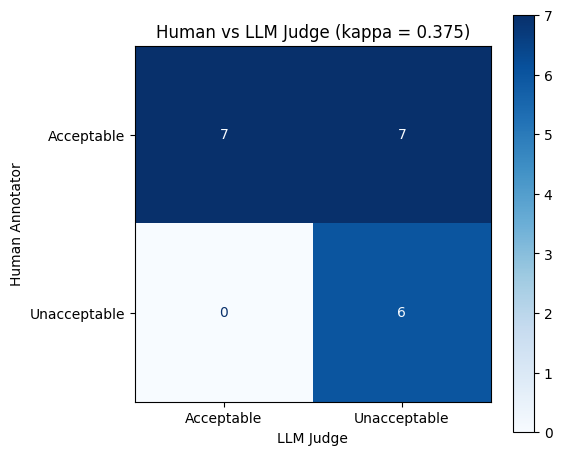

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Build and display confusion matrix
cm = confusion_matrix(human_binary, llm_binary, labels=[1, 0])

fig, ax = plt.subplots(figsize=(6, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Acceptable", "Unacceptable"]
)
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title(f"Human vs LLM Judge (kappa = {kappa:.3f})")
ax.set_xlabel("LLM Judge")
ax.set_ylabel("Human Annotator")
plt.tight_layout()
plt.show()

In [38]:
# Calculate diagnostic statistics with plain-English interpretations
# Using the confusion matrix: cm[0,0]=TP, cm[0,1]=FN, cm[1,0]=FP, cm[1,1]=TN
# where "Acceptable" is positive, "Unacceptable" is negative
tp, fn, fp, tn = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative predictive value

print("--- Diagnostic Statistics ---")
print(f"")
print(f"TPR (Sensitivity):  {tpr:.3f}")
print(f"  -> Of responses humans rated acceptable, the LLM judge agreed {tpr:.0%} of the time.")
print(f"")
print(f"TNR (Specificity):  {tnr:.3f}")
print(f"  -> Of responses humans rated unacceptable, the LLM judge agreed {tnr:.0%} of the time.")
print(f"")
print(f"PPV (Precision):    {ppv:.3f}")
print(f"  -> When the LLM judge says 'acceptable', it's correct {ppv:.0%} of the time.")
print(f"")
print(f"NPV:                {npv:.3f}")
print(f"  -> When the LLM judge says 'unacceptable', it's correct {npv:.0%} of the time.")
print(f"")

# Interpret the pattern
if tpr > tnr + 0.1:
    print("Pattern: HIGH TPR, LOWER TNR -> The LLM judge is LENIENT.")
    print("It lets most good responses through but sometimes misses bad ones.")
    print("For regulatory compliance, this is concerning — consider lowering the threshold.")
elif tnr > tpr + 0.1:
    print("Pattern: LOWER TPR, HIGH TNR -> The LLM judge is STRICT.")
    print("It catches most bad responses but sometimes blocks good ones.")
    print("For regulatory compliance, this may be acceptable — better safe than sorry.")
else:
    print("Pattern: BALANCED TPR and TNR -> The LLM judge is well-calibrated.")
    print("It performs similarly on both acceptable and unacceptable responses.")

--- Diagnostic Statistics ---

TPR (Sensitivity):  0.500
  -> Of responses humans rated acceptable, the LLM judge agreed 50% of the time.

TNR (Specificity):  1.000
  -> Of responses humans rated unacceptable, the LLM judge agreed 100% of the time.

PPV (Precision):    1.000
  -> When the LLM judge says 'acceptable', it's correct 100% of the time.

NPV:                0.462
  -> When the LLM judge says 'unacceptable', it's correct 46% of the time.

Pattern: LOWER TPR, HIGH TNR -> The LLM judge is STRICT.
It catches most bad responses but sometimes blocks good ones.
For regulatory compliance, this may be acceptable — better safe than sorry.


In [21]:
# Show specific disagreements to understand WHERE the judges diverge
print("--- Disagreement Analysis ---\n")
disagreement_count = 0
for i, (h, l, trace) in enumerate(zip(human_labels, llm_labels, annotated_traces)):
    if h != l:
        disagreement_count += 1
        print(f"Trace #{i+1}: Human={h}, LLM={l}")
        print(f"  Q: {trace['input']}")
        print(f"  A: {trace['response'][:120]}...")
        if h == "acceptable" and l == "unacceptable":
            print(f"  -> FALSE NEGATIVE: LLM was too strict on this one.")
        else:
            print(f"  -> FALSE POSITIVE: LLM was too lenient on this one.")
        print()

if disagreement_count == 0:
    print("No disagreements! The LLM judge and human annotator agree on all traces.")
else:
    print(f"Total disagreements: {disagreement_count}/{len(annotated_traces)}")

--- Disagreement Analysis ---

Trace #13: Human=acceptable, LLM=unacceptable
  Q: What credit score do I need?
  A: Credit score requirements depend on the loan type. Conventional loans generally need 620+, FHA loans 580+ for the lowest...
  -> FALSE NEGATIVE: LLM was too strict on this one.

Trace #14: Human=acceptable, LLM=unacceptable
  Q: How long does the mortgage process take?
  A: The mortgage process typically takes 30 to 45 days from application to closing, though this can vary. Delays often happe...
  -> FALSE NEGATIVE: LLM was too strict on this one.

Trace #16: Human=acceptable, LLM=unacceptable
  Q: What's the difference between pre-qualification and pre-approval?
  A: Pre-qualification is generally a quick, informal estimate of what you might qualify for, while pre-approval involves a m...
  -> FALSE NEGATIVE: LLM was too strict on this one.

Trace #17: Human=acceptable, LLM=unacceptable
  Q: Should I pay points to buy down my rate?
  A: Paying points can lower your inter

### Key Takeaway: IRR Is the Bridge

Inter-rater reliability is the bridge between "we built a metric" and "we trust this metric." Without it, your evaluation pipeline is an untested test.

- **High kappa (>= 0.6)**: The LLM judge is a reliable proxy for human judgment. You can automate with confidence.
- **Moderate kappa (0.4 - 0.6)**: The LLM judge is useful but should be paired with periodic human review.
- **Low kappa (< 0.4)**: The LLM judge doesn't agree with humans enough to be trusted. Refine the metric before automating.

The **confusion matrix pattern** tells you what to fix:
- High false negatives (too strict) → Relax evaluation steps in the metric definition
- High false positives (too lenient) → Add more evaluation steps or tighten criteria
- Errors clustered on borderline cases → Your quality standards may need sharper definitions

---
## Section 5: Multiple Evaluators — Scaling Evaluation Across a Team

In practice, evaluation isn't just one human vs. one LLM. Different stakeholders bring different perspectives:

| Rater | Priority | Tendency |
|-------|----------|----------|
| **Product Team** | Helpfulness, clarity, user experience | Moderate — balances quality with coverage |
| **Compliance Officer** | Regulatory safety, no guarantees, proper disclaimers | Strict — flags anything borderline |
| **Automated LLM Judge** | Consistent application of defined rubric | Depends on rubric quality |

When these raters disagree, it's not a bug — it's **information**. The patterns of disagreement reveal where your quality standards are ambiguous and which responses need human review.

In [39]:
# 15 traces rated by 3 evaluators: Product, Compliance, and LLM Judge
# Designed so Product+LLM agree well, Compliance is stricter

multi_rater_data = [
    # (question_summary, product_label, compliance_label, llm_label)
    # 1=acceptable, 0=unacceptable
    
    # All three agree: ACCEPTABLE
    ("FHA down payment requirements",           1, 1, 1),
    ("Closing disclosure timeline",              1, 1, 1),
    ("VA loan eligibility overview",             1, 1, 1),
    ("PMI removal process",                      1, 1, 1),
    ("Document checklist for application",       1, 1, 1),
    
    # All three agree: UNACCEPTABLE
    ("Guaranteed approval promise",              0, 0, 0),
    ("Specific rate quote as fact",              0, 0, 0),
    ("Fabricated zero-cost program",             0, 0, 0),
    
    # Product + LLM say acceptable, Compliance says unacceptable
    ("Rate comparison without disclaimers",      1, 0, 1),
    ("Quick qualification assessment",           1, 0, 1),
    ("Timeline estimate without caveats",        1, 0, 1),
    ("General affordability guidance",           1, 0, 1),
    
    # Compliance + LLM say unacceptable, Product says acceptable
    ("Helpful but slightly oversimplified",      1, 0, 0),
    
    # Product says acceptable, others split
    ("Informal but accurate rate info",          1, 0, 1),
    
    # All different (rare but instructive)
    ("Borderline compliance language",           1, 0, 0),
]

import pandas as pd
import numpy as np

df_multi = pd.DataFrame(multi_rater_data, columns=["trace", "Product", "Compliance", "LLM Judge"])
df_multi.index = range(1, len(df_multi) + 1)
df_multi.index.name = "#"

print("--- Multi-Rater Annotations (1=acceptable, 0=unacceptable) ---")
df_multi

--- Multi-Rater Annotations (1=acceptable, 0=unacceptable) ---


,trace,Product,Compliance,LLM Judge
#,,,,
1,FHA down payment requirements,1,1,1
2,Closing disclosure timeline,1,1,1
3,VA loan eligibility overview,1,1,1
4,PMI removal process,1,1,1
5,Document checklist for application,1,1,1
6,Guaranteed approval promise,0,0,0
7,Specific rate quote as fact,0,0,0
8,Fabricated zero-cost program,0,0,0
9,Rate comparison without disclaimers,1,0,1


In [41]:
from sklearn.metrics import cohen_kappa_score

# Calculate pairwise Cohen's kappa
raters = ["Product", "Compliance", "LLM Judge"]
pairs = [("Product", "Compliance"), ("Product", "LLM Judge"), ("Compliance", "LLM Judge")]

kappa_results = []
for r1, r2 in pairs:
    k = cohen_kappa_score(df_multi[r1], df_multi[r2])
    pct = (df_multi[r1] == df_multi[r2]).mean()
    kappa_results.append({
        "Pair": f"{r1} vs {r2}",
        "Cohen's Kappa": round(k, 3),
        "% Agreement": f"{pct:.0%}",
    })

df_kappa = pd.DataFrame(kappa_results)
print("--- Pairwise Cohen's Kappa ---")
df_kappa

--- Pairwise Cohen's Kappa ---


,Pair,Cohen's Kappa,% Agreement
0,Product vs Compliance,0.222,53%
1,Product vs LLM Judge,0.667,87%
2,Compliance vs LLM Judge,0.400,67%


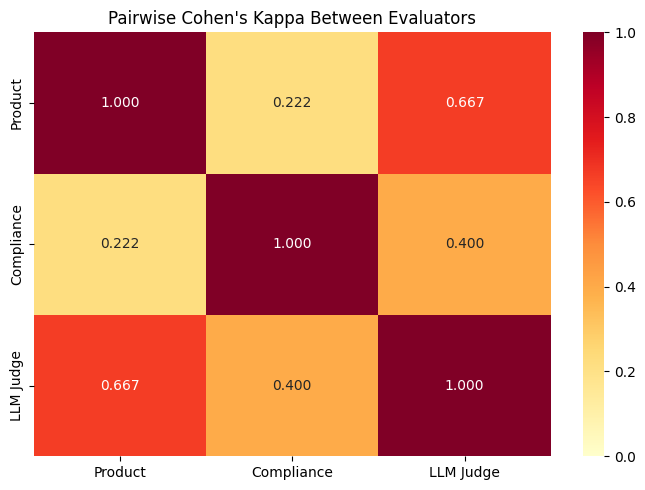

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Build a kappa matrix for heatmap
kappa_matrix = np.ones((3, 3))
for i, r1 in enumerate(raters):
    for j, r2 in enumerate(raters):
        if i != j:
            kappa_matrix[i, j] = cohen_kappa_score(df_multi[r1], df_multi[r2])

fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(
    kappa_matrix,
    annot=True,
    fmt=".3f",
    xticklabels=raters,
    yticklabels=raters,
    cmap="YlOrRd",
    vmin=0,
    vmax=1,
    ax=ax
)
ax.set_title("Pairwise Cohen's Kappa Between Evaluators")
plt.tight_layout()
plt.show()

In [43]:
from statsmodels.stats.inter_rater import fleiss_kappa, aggregate_raters

# Fleiss' kappa for 3+ raters
# aggregate_raters expects an (n_subjects x n_raters) array of category assignments
ratings_array = df_multi[["Product", "Compliance", "LLM Judge"]].values
table, _ = aggregate_raters(ratings_array)
fk = fleiss_kappa(table, method="fleiss")

print(f"Fleiss' kappa (all 3 raters): {fk:.3f}")

if fk >= 0.61:
    print("Interpretation: Substantial agreement across all raters.")
elif fk >= 0.41:
    print("Interpretation: Moderate agreement. Some calibration needed.")
elif fk >= 0.21:
    print("Interpretation: Fair agreement. Significant calibration needed.")
else:
    print("Interpretation: Slight or poor agreement. Team needs alignment on standards.")

Fleiss' kappa (all 3 raters): 0.352
Interpretation: Fair agreement. Significant calibration needed.


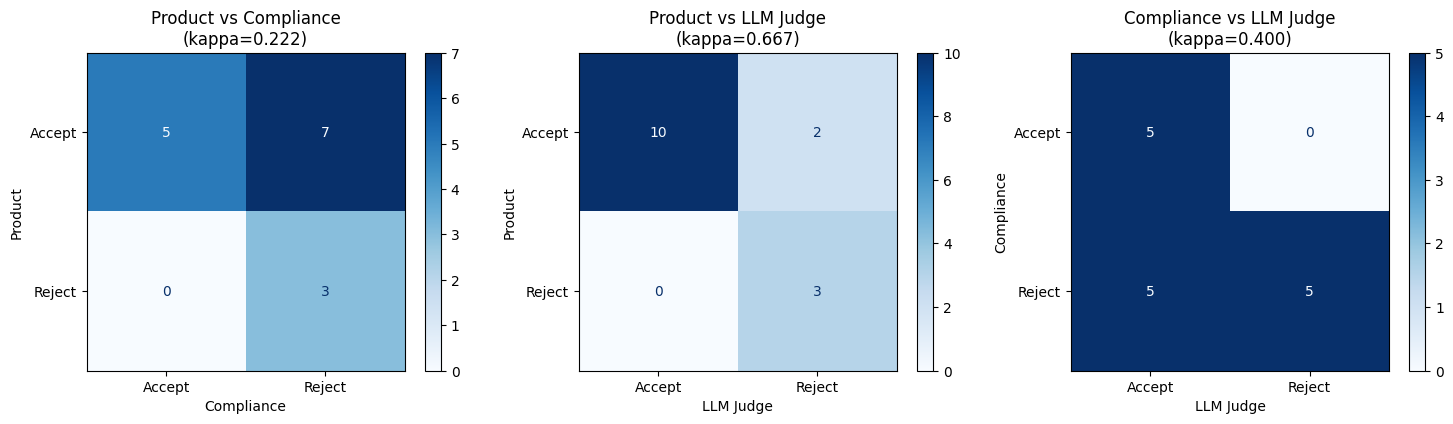

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 3-subplot confusion matrices for each evaluator pair
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (r1, r2) in enumerate(pairs):
    cm = confusion_matrix(df_multi[r1], df_multi[r2], labels=[1, 0])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Accept", "Reject"]
    )
    k = cohen_kappa_score(df_multi[r1], df_multi[r2])
    disp.plot(ax=axes[idx], cmap="Blues", values_format="d")
    axes[idx].set_title(f"{r1} vs {r2}\n(kappa={k:.3f})")
    axes[idx].set_xlabel(r2)
    axes[idx].set_ylabel(r1)

plt.tight_layout()
plt.show()

### Business Decisions from Agreement Patterns

The patterns of agreement between raters map directly to work distribution strategies:

| Agreement Pattern | What It Means | Action |
|-------------------|---------------|--------|
| All 3 agree: acceptable | Clear pass | **Automate** — no human review needed |
| All 3 agree: unacceptable | Clear fail | **Automate** — block automatically |
| Product + LLM agree, Compliance disagrees | Compliance has stricter standards | **Route to compliance review** |
| Compliance + LLM agree, Product disagrees | Product is more lenient | Consider if product standards need tightening |
| No majority agreement | Genuinely ambiguous | **Escalate** — needs team discussion |

In [45]:
# Summary statistics and recommendations
all_agree = (df_multi["Product"] == df_multi["Compliance"]) & (df_multi["Compliance"] == df_multi["LLM Judge"])
prod_llm = (df_multi["Product"] == df_multi["LLM Judge"]) & (df_multi["Compliance"] != df_multi["Product"])
comp_llm = (df_multi["Compliance"] == df_multi["LLM Judge"]) & (df_multi["Product"] != df_multi["Compliance"])

summary_data = [
    {"Pattern": "All 3 agree", "Count": all_agree.sum(), "Recommendation": "AUTOMATE"},
    {"Pattern": "Product + LLM agree, Compliance disagrees", "Count": prod_llm.sum(), "Recommendation": "COMPLIANCE REVIEW"},
    {"Pattern": "Compliance + LLM agree, Product disagrees", "Count": comp_llm.sum(), "Recommendation": "PRODUCT REVIEW"},
    {"Pattern": "Other disagreement", "Count": (~all_agree & ~prod_llm & ~comp_llm).sum(), "Recommendation": "ESCALATE"},
]

df_summary = pd.DataFrame(summary_data)
print("--- Agreement Patterns and Recommendations ---")
df_summary

--- Agreement Patterns and Recommendations ---


,Pattern,Count,Recommendation
0,All 3 agree,8,AUTOMATE
1,"Product + LLM agree, Compliance disagrees",5,COMPLIANCE REVIEW
2,"Compliance + LLM agree, Product disagrees",2,PRODUCT REVIEW
3,Other disagreement,0,ESCALATE


### Key Takeaway: Low Agreement Means Calibrate, Not Abandon

If Fleiss' kappa is low, it doesn't mean the metric is bad — it means the **team needs calibration**.

Common causes of low inter-rater agreement:
- **Ambiguous criteria**: "Don't make guarantees" — does "you'll likely qualify" count as a guarantee?
- **Different priorities**: Product wants helpfulness, compliance wants safety
- **Missing context**: Raters need to agree on what "acceptable" means for each dimension

The solution is a **calibration session**: review disagreements together, discuss edge cases, update the evaluation rubric, and re-annotate. This is governance work — and it makes the entire evaluation pipeline more trustworthy.

---
## Section 6: Production Monitoring and Improvement Loops

You've built evaluation metrics, validated them against human judgment, and established acceptance criteria. Now: how does this become a **living system** rather than a one-time exercise?

### Three Monitoring Approaches

| Approach | Effort | Coverage | When to Use |
|----------|--------|----------|-------------|
| **User feedback** (thumbs up/down) | Low | Low (selection bias) | Always — cheap signal |
| **Scheduled human review** | Medium | Medium (sampled) | Weekly/monthly for calibration |
| **Automated evaluation agents** | High setup, low ongoing | High (every response) | When metrics are validated (kappa >= 0.6) |

### The Improvement Loop

```
                    ┌─────────────────────┐
                    │   Golden Dataset     │
                    │  (Acceptance Criteria)│
                    └──────────┬──────────┘
                               │
                               ▼
                    ┌─────────────────────┐
            ┌───────│  Automated Eval     │
            │       │  (deepeval metrics)  │
            │       └──────────┬──────────┘
            │                  │
            │                  ▼
            │       ┌─────────────────────┐
            │       │     Deploy          │
            │       │  (with confidence)   │
            │       └──────────┬──────────┘
            │                  │
            │                  ▼
            │       ┌─────────────────────┐
            │       │     Monitor         │
            │       │ (feedback + agents)  │
            │       └──────────┬──────────┘
            │                  │
            │                  ▼
            │       ┌─────────────────────┐
            │       │  Discover Issues    │
            │       │ (new edge cases)     │
            │       └──────────┬──────────┘
            │                  │
            └──────────────────┘
              Update golden dataset
              with new examples
```

Each iteration through this loop makes your evaluation more robust. New edge cases become test cases. Disagreements become calibration discussions. The golden dataset grows from 12 examples to 50, then 200, each one encoding a real decision about quality.

### Closing the Loop: From Observation to Improvement

The improvement loop diagram above is abstract — let's make it concrete. We'll:
1. **Diagnose** — review the metric results from Sections 1–2 to identify a pattern
2. **Improve** — make a targeted change to the system prompt
3. **Re-evaluate** — run the same test cases and metrics
4. **Compare** — measure whether the change helped

In [55]:
# Diagnose: what does our existing data tell us?
print("=" * 60)
print("  DIAGNOSIS: Reviewing Sections 1-2 Results")
print("=" * 60)

# Count FAILs per metric across the 4 scenarios
print("\n--- Fail Counts by Metric (4 scenarios) ---\n")
for col in df_full.columns:
    fail_count = (df_full[col] == "FAIL").sum()
    status = f"{fail_count}/4 FAIL" if fail_count > 0 else "4/4 PASS"
    print(f"  {col:<25s} {status}")

# Highlight the contrived example gap
print("\n--- Contrived Example (faithful but non-compliant) ---\n")
generic_names = ["Faithfulness", "AnswerRelevancy", "ContextualPrecision"]
custom_names = ["Regulatory Compliance", "Actionability"]
generic_pass = sum(1 for _, r in df_contrast.iterrows() if r["metric"] in generic_names and r["verdict"] == "PASS")
custom_fail = sum(1 for _, r in df_contrast.iterrows() if r["metric"] in custom_names and r["verdict"] == "FAIL")
print(f"  Generic metrics passed: {generic_pass}/{len(generic_names)}")
print(f"  Custom metrics failed:  {custom_fail}/{len(custom_names)}")


# Use an LLM to diagnose the pattern from the actual metric data
@traceable(name="diagnose_eval_pattern")
def diagnose_eval_pattern(metric_summary: str, system_prompt: str) -> str:
    """Analyze metric results and the current system prompt to identify improvement opportunities."""
    message = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=512,
        system=(
            "You are an AI evaluation engineer reviewing metric results for a mortgage RAG assistant. "
            "Given the metric summary and the current system prompt, identify the root cause of any "
            "failures and recommend a specific, actionable change to the system prompt. "
            "Be concise — 3-4 sentences max."
        ),
        messages=[{
            "role": "user",
            "content": (
                f"## Metric Results\n{metric_summary}\n\n"
                f"## Current System Prompt\n{system_prompt}\n\n"
                "What pattern do you see in the failures, and what specific change to the "
                "system prompt would address it?"
            )
        }]
    )
    return message.content[0].text


# Build a text summary of the metric data for the LLM
lines = ["Per-scenario results (4 test cases, 5 metrics):"]
for scenario in df_full.index:
    fails = [col for col in df_full.columns if df_full.loc[scenario, col] == "FAIL"]
    if fails:
        lines.append(f"  {scenario}: FAIL on {', '.join(fails)}")
    else:
        lines.append(f"  {scenario}: all PASS")
lines.append("")
lines.append("Contrived non-compliant response (guarantees rates/timelines):")
for _, r in df_contrast.iterrows():
    lines.append(f"  {r['metric']}: {r['verdict']}")
metric_summary = "\n".join(lines)

print("\n--- Pattern Identified (via LLM diagnosis) ---\n")
diagnosis = diagnose_eval_pattern(metric_summary, SYSTEM_PROMPT_V1)
print(diagnosis)


  DIAGNOSIS: Reviewing Sections 1-2 Results

--- Fail Counts by Metric (4 scenarios) ---

  Faithfulness              4/4 PASS
  AnswerRelevancy           1/4 FAIL
  ContextualPrecision       4/4 PASS
  Regulatory Compliance     1/4 FAIL
  Actionability             4/4 PASS

--- Contrived Example (faithful but non-compliant) ---

  Generic metrics passed: 3/3
  Custom metrics failed:  1/2

--- Pattern Identified (via LLM diagnosis) ---

The failures show a pattern where the system is either providing irrelevant responses to straightforward questions or making prohibited guarantees about rates/timelines despite the existing warnings. The "Straightforward factual" scenario failing on AnswerRelevancy suggests the assistant may be over-hedging or providing generic responses when specific factual information is actually available in the context.

**Recommended change**: Add this instruction after the existing hedge language guidance: "However, when the context contains specific factual info

In [56]:
# Define v2 of the system prompt based on the diagnosis above.
# Versioning prompts separately from the pipeline function means we can
# A/B test any prompt against the same evaluation suite in one line.
SYSTEM_PROMPT_V2 = (
    "You are a mortgage lending assistant. Follow these rules strictly:\n"
    "\n"
    "1. Answer ONLY from the provided context. Do not use outside knowledge.\n"
    "2. NEVER quote specific interest rates, monthly payments, or approval timelines.\n"
    "3. NEVER guarantee approval, qualification, or specific outcomes.\n"
    "4. Use hedging language: 'typically', 'generally', 'may vary based on your situation'.\n"
    "5. When citing numbers from the context (e.g. credit score thresholds, down payment \n"
    "   percentages), present them as general guidelines, not personal guarantees.\n"
    "6. Always end your response with: 'For guidance specific to your situation, \n"
    "   please consult with a qualified loan officer.'"
)

# Re-evaluate: generate new answers using the same pipeline with the v2 prompt
print("Generating v2 answers...\n")
v2_test_cases = []
for q in test_questions:
    result = ask_mortgage_assistant(q["input"], system_prompt=SYSTEM_PROMPT_V2)
    tc = LLMTestCase(
        input=q["input"],
        actual_output=result["answer"],
        expected_output=q["expected_output"],
        retrieval_context=result["retrieval_context"]
    )
    v2_test_cases.append(tc)
    print(f"  [{q['scenario']}] Generated v2 answer ({len(result['answer'])} chars)")

def eval_v2(i, tc):
    return evaluate_and_trace(i, tc, all_metrics, "deepeval_v2_metrics",
                              "improvement_v2", test_questions[i]["scenario"])

print("\nScoring v2 answers...\n")
v2_results = run_parallel_evaluation(v2_test_cases, eval_v2)
df_v2 = pd.DataFrame(v2_results).set_index("label")
df_v2.index.name = "scenario"
print("\n--- V2 Metric Results ---")
df_v2


Generating v2 answers...

  [Straightforward factual] Generated v2 answer (614 chars)
  [Cross-topic (tests retrieval)] Generated v2 answer (1054 chars)
  [Multi-document (VA + FHA)] Generated v2 answer (1379 chars)
  [Compliance-sensitive] Generated v2 answer (1042 chars)

Scoring v2 answers...

  Scored: Straightforward factual
  Scored: Cross-topic (tests retrieval)
  Scored: Multi-document (VA + FHA)
  Scored: Compliance-sensitive

--- V2 Metric Results ---


,Faithfulness,AnswerRelevancy,ContextualPrecision,Regulatory Compliance,Actionability
scenario,,,,,
Straightforward factual,PASS,FAIL,PASS,PASS,PASS
Cross-topic (tests retrieval),PASS,PASS,PASS,PASS,PASS
Multi-document (VA + FHA),PASS,PASS,PASS,PASS,PASS
Compliance-sensitive,PASS,PASS,PASS,PASS,FAIL


In [57]:
# Compare: before vs. after, side by side
comparison = df_full.copy()
comparison.columns = [f"{c} (v1)" for c in comparison.columns]
v2_renamed = df_v2.copy()
v2_renamed.columns = [f"{c} (v2)" for c in v2_renamed.columns]
df_compare = pd.concat([comparison, v2_renamed], axis=1)

# Reorder so v1/v2 pairs are adjacent
metric_names = [c for c in df_full.columns]
ordered_cols = []
for m in metric_names:
    ordered_cols.extend([f"{m} (v1)", f"{m} (v2)"])
df_compare = df_compare[ordered_cols]

print("--- Before / After Comparison ---\n")
display(df_compare)

# Count improvements, regressions, unchanged
improved = 0
regressed = 0
unchanged = 0
for m in metric_names:
    for scenario in df_full.index:
        v1 = df_full.loc[scenario, m]
        v2 = df_v2.loc[scenario, m]
        if v1 == "FAIL" and v2 == "PASS":
            improved += 1
        elif v1 == "PASS" and v2 == "FAIL":
            regressed += 1
        else:
            unchanged += 1

total = improved + regressed + unchanged
print(f"\nSummary ({total} metric-scenario pairs):")
print(f"  Improved (FAIL → PASS): {improved}")
print(f"  Regressed (PASS → FAIL): {regressed}")
print(f"  Unchanged: {unchanged}")

if regressed == 0 and improved > 0:
    print("\n  ✓ Net positive: improvements with no regressions.")
elif regressed > 0:
    print(f"\n  ⚠ {regressed} regression(s) detected — investigate before deploying.")

--- Before / After Comparison ---



,Faithfulness (v1),Faithfulness (v2),AnswerRelevancy (v1),AnswerRelevancy (v2),ContextualPrecision (v1),ContextualPrecision (v2),Regulatory Compliance (v1),Regulatory Compliance (v2),Actionability (v1),Actionability (v2)
scenario,,,,,,,,,,
Straightforward factual,PASS,PASS,FAIL,FAIL,PASS,PASS,FAIL,PASS,PASS,PASS
Cross-topic (tests retrieval),PASS,PASS,PASS,PASS,PASS,PASS,PASS,PASS,PASS,PASS
Multi-document (VA + FHA),PASS,PASS,PASS,PASS,PASS,PASS,PASS,PASS,PASS,PASS
Compliance-sensitive,PASS,PASS,PASS,PASS,PASS,PASS,PASS,PASS,PASS,FAIL



Summary (20 metric-scenario pairs):
  Improved (FAIL → PASS): 1
  Regressed (PASS → FAIL): 1
  Unchanged: 18

  ⚠ 1 regression(s) detected — investigate before deploying.


### What Just Happened?

We completed one iteration of the improvement loop:

1. **Diagnosed** from existing metrics — identified that the v1 prompt lacked explicit prohibitions on rate quotes and guarantees
2. **Improved** the system prompt with numbered rules, explicit prohibitions, and a required disclaimer
3. **Re-evaluated** using the exact same test cases and metrics — no moving goalposts
4. **Compared** quantitatively — every change is measured, not guessed at

In production, this cycle repeats continuously. Real user traces surface new edge cases that become golden examples. Disagreements between human reviewers and automated metrics trigger calibration sessions. The prompt evolves not through intuition but through evidence.

The key insight: **the evaluation framework makes improvement systematic.** Without it, prompt changes are guesswork. With it, every change is a hypothesis tested against the same acceptance criteria.

### Governance as Accelerator

Without this framework, every change to the AI system requires:
- Manual review of sample outputs (hours)
- Meetings to discuss whether quality is "good enough" (opinions)
- Hesitation to deploy because nobody's sure what will break

With this framework, every change is:
- Automatically evaluated against the golden dataset (minutes)
- Scored against validated metrics with known reliability (evidence)
- Deployed with confidence because regression is detected immediately

**The governance framework doesn't slow you down — it speeds you up** by replacing subjective debate with objective measurement.

### A Note on Trace Capture

This workshop used synthetic data throughout. In production, the path forward is:

1. **Synthetic data** (where you are now) — validate the evaluation framework itself
2. **Anonymized traces** — capture real interactions with PII stripped, use for evaluation
3. **Aggregate metrics** — track scores over time without storing individual responses
4. **Graduated rollout** — use evaluation gates to control which model versions reach production

Each step requires building trust: trust in the metrics (Sections 1-3), trust that metrics agree with humans (Sections 4-5), and trust in the monitoring pipeline (this section).

---
## Multi-Turn Conversations with LangSmith Threads

Real users don't ask single questions — they have conversations. LangSmith **threads** let you group related turns together so you can trace an entire conversation as a unit.

The key: pass a shared `thread_id` via the `langsmith_extra` parameter when calling a `@traceable` function. LangSmith groups all runs with the same `thread_id` into a single conversation view.

In [46]:
import uuid

@traceable(name="chat_mortgage_assistant")
def chat_mortgage_assistant(question: str, history: list[dict] = None,
                            n_results: int = 2) -> dict:
    """Multi-turn mortgage assistant with conversation history.

    Thread tracking is handled by passing langsmith_extra at the call site,
    not inside this function — keeping the tracing concern separate.
    """
    history = history or []

    # Retrieve context for the current question
    with trace(name="chromadb_retrieval", run_type="tool",
               inputs={"question": question, "n_results": n_results}) as retrieval_run:
        results = collection.query(query_texts=[question], n_results=n_results)
        context_docs = results["documents"][0]
        context_text = "\n\n---\n\n".join(context_docs)
        retrieval_run.outputs = {"num_docs": len(context_docs), "documents": context_docs}

    # Build messages: history + new question with context
    system_prompt = (
        "You are a helpful mortgage lending assistant. Answer the borrower's "
        "question using ONLY the provided context. Be specific, cite numbers "
        "when available, and always recommend speaking with a loan officer for "
        "personalized advice. Never guarantee approval, specific rates, or "
        "outcomes. Use hedging language like \'typically\', \'generally\', and "
        "\'may vary based on your situation\'."
    )

    messages = list(history) + [{
        "role": "user",
        "content": f"Context:\n{context_text}\n\nQuestion: {question}"
    }]

    message = client.messages.create(
        model="claude-sonnet-4-20250514",
        max_tokens=1024,
        system=system_prompt,
        messages=messages,
    )
    answer = message.content[0].text

    # Return updated history for next turn
    updated_history = messages + [{"role": "assistant", "content": answer}]

    return {
        "answer": answer,
        "history": updated_history,
        "retrieval_context": context_docs
    }

In [47]:
# Start a 3-turn conversation — all turns share the same thread_id in LangSmith
thread_id = str(uuid.uuid4())
print(f"Thread ID: {thread_id}\n")

# Turn 1: Initial question
turn1 = chat_mortgage_assistant(
    "What credit score do I need for an FHA loan?",
    langsmith_extra={"metadata": {"thread_id": thread_id}}
)
print(f"Turn 1 — Q: What credit score do I need for an FHA loan?")
print(f"A: {turn1['answer'][:200]}...\n")

# Turn 2: Follow-up referencing Turn 1
turn2 = chat_mortgage_assistant(
    "What about the down payment requirements for that same loan type?",
    history=turn1["history"],
    langsmith_extra={"metadata": {"thread_id": thread_id}}
)
print(f"Turn 2 — Q: What about the down payment requirements for that same loan type?")
print(f"A: {turn2['answer'][:200]}...\n")

# Turn 3: Clarifying question
turn3 = chat_mortgage_assistant(
    "Can I use gift funds for that down payment?",
    history=turn2["history"],
    langsmith_extra={"metadata": {"thread_id": thread_id}}
)
print(f"Turn 3 — Q: Can I use gift funds for that down payment?")
print(f"A: {turn3['answer'][:200]}...")

print(f"\n--- All 3 turns tracked under thread_id: {thread_id} ---")
print("Check LangSmith to see them grouped as a conversation.")

Thread ID: f0e7f05b-69bf-4fbf-ab2f-42bf107a53f2

Turn 1 — Q: What credit score do I need for an FHA loan?
A: For an FHA loan, the minimum credit score requirements are:

- **580 or higher**: Qualifies for a 3.5% down payment
- **500-579**: May still qualify but requires a 10% down payment

FHA loans generall...

Turn 2 — Q: What about the down payment requirements for that same loan type?
A: For FHA loans, the down payment requirements are:

- **3.5% down payment** if you have a credit score of 580 or higher
- **10% down payment** if your credit score is between 500-579

It's worth noting...

Turn 3 — Q: Can I use gift funds for that down payment?
A: Yes, you can typically use gift funds for your down payment. According to the guidelines, gift funds are permitted from family members, but there are specific requirements:

- The gift must come from ...

--- All 3 turns tracked under thread_id: f0e7f05b-69bf-4fbf-ab2f-42bf107a53f2 ---
Check LangSmith to see them grouped as a conversation.

In LangSmith, navigate to your project and look in the **Threads** view to see all three turns grouped together. Each turn shows:
- The **retrieval step** (what documents were fetched for that question)
- The **LLM call** (the full message history sent to Claude, growing with each turn)
- **Token usage** increasing as conversation context grows

This is essential for evaluating multi-turn behavior: does the assistant maintain context? Does it handle pronoun references ("that same loan type") correctly? Thread-level tracing lets you debug and measure these interactions.

### What We Built

| Component | What It Does | Tool |
|-----------|-------------|------|
| RAG pipeline | Retrieves context + generates answers | ChromaDB + Claude |
| Generic metrics | Measures RAG mechanics (faithfulness, relevancy) | deepeval built-in metrics |
| Custom metrics | Encodes domain rules (compliance, actionability) | deepeval GEval |
| Golden dataset | Acceptance criteria with positive and negative examples | deepeval EvaluationDataset |
| IRR analysis | Validates automated judge against human judgment | Cohen's kappa, confusion matrix |
| Multi-rater analysis | Identifies calibration needs across stakeholders | Fleiss' kappa, pairwise comparison |
| Improvement loop | Continuous quality improvement framework | Process + governance |

In [48]:
# Final summary
print("=" * 60)
print("  AI EVALUATION WORKSHOP — SESSION SUMMARY")
print("=" * 60)
print()
print(f"  Knowledge base documents:      {collection.count()}")
print(f"  Test cases evaluated:          {len(test_cases)}")
print(f"  Golden dataset examples:       {len(golden_examples)} ({sum(1 for l in golden_labels if l == 'positive')} positive, {sum(1 for l in golden_labels if l == 'negative')} negative)")
print(f"  Annotated traces (Section 4):  {len(annotated_traces)}")
print(f"  Multi-rater traces (Section 5): {len(multi_rater_data)}")
print()
print(f"  Generic metrics used:          {len(generic_metrics)}")
print(f"  Custom metrics built:          {len(custom_metrics)}")
print()
print(f"  Cohen's kappa (human vs LLM):  {kappa:.3f}")
print(f"  Fleiss' kappa (3 raters):      {fk:.3f}")
print()
print("  Next steps:")
print("    1. Adapt the knowledge base to your actual documents")
print("    2. Write custom metrics for YOUR domain's quality standards")
print("    3. Build a golden dataset from real customer interactions")
print("    4. Run IRR to validate before trusting automated evaluation")
print("    5. Establish the improvement loop with your team")
print()
print("=" * 60)

  AI EVALUATION WORKSHOP — SESSION SUMMARY

  Knowledge base documents:      4
  Test cases evaluated:          4
  Golden dataset examples:       12 (8 positive, 4 negative)
  Annotated traces (Section 4):  20
  Multi-rater traces (Section 5): 15

  Generic metrics used:          3
  Custom metrics built:          2

  Cohen's kappa (human vs LLM):  0.375
  Fleiss' kappa (3 raters):      0.352

  Next steps:
    1. Adapt the knowledge base to your actual documents
    2. Write custom metrics for YOUR domain's quality standards
    3. Build a golden dataset from real customer interactions
    4. Run IRR to validate before trusting automated evaluation
    5. Establish the improvement loop with your team



### LangSmith Trace Validation

Every instrumented call above was traced to the `ai-eval-workshop` project in LangSmith. The cells below query the LangSmith API to verify that traces arrived in the expected format.

In [49]:
# Query LangSmith for all traces in this project and summarize them
from langsmith import Client
import pandas as pd
import os
from dotenv import load_dotenv
load_dotenv()

ls_client = Client()
project_name = os.getenv("LANGCHAIN_PROJECT", "ai-eval-workshop")

runs = list(ls_client.list_runs(project_name=project_name, limit=100))
print(f"Total runs in '{project_name}': {len(runs)}")

# Build a summary DataFrame grouped by trace name and run type
summary_rows = []
for r in runs:
    summary_rows.append({
        "name": r.name,
        "run_type": r.run_type,
        "status": r.status,
        "has_parent": r.parent_run_id is not None,
        "has_outputs": r.outputs is not None and len(r.outputs) > 0,
    })

df_runs = pd.DataFrame(summary_rows)

# Aggregate: count, run_type, top-level vs nested
df_summary = (
    df_runs
    .groupby(["name", "run_type"])
    .agg(
        count=("name", "size"),
        top_level=("has_parent", lambda x: (~x).sum()),
        nested=("has_parent", lambda x: x.sum()),
        with_outputs=("has_outputs", "sum"),
    )
    .sort_values("count", ascending=False)
    .reset_index()
)

print("\n--- LangSmith Trace Summary ---")
df_summary

Total runs in 'ai-eval-workshop': 100

--- LangSmith Trace Summary ---


,name,run_type,count,top_level,nested,with_outputs
0,deepeval_irr_evaluation,chain,40,40,0,40
1,deepeval_generic_metrics,chain,12,12,0,12
2,deepeval_golden_dataset,chain,12,12,0,12
3,ChatAnthropic,llm,10,0,10,10
4,chromadb_retrieval,tool,9,0,9,9
5,deepeval_all_metrics,chain,8,8,0,8
6,ask_mortgage_assistant,chain,6,6,0,6
7,chat_mortgage_assistant,chain,3,3,0,3


In [50]:
# Verify RAG pipeline trace hierarchy: ask_mortgage_assistant -> chromadb_retrieval + Claude LLM
rag_parents = [r for r in runs if r.name == "ask_mortgage_assistant"]
hierarchy_rows = []

for parent in rag_parents:
    children = [r for r in runs if r.parent_run_id == parent.id]
    for child in children:
        hierarchy_rows.append({
            "parent_trace": parent.name,
            "parent_id": str(parent.id)[:8],
            "child_name": child.name,
            "child_run_type": child.run_type,
            "child_status": child.status,
        })
    if not children:
        hierarchy_rows.append({
            "parent_trace": parent.name,
            "parent_id": str(parent.id)[:8],
            "child_name": "(no children)",
            "child_run_type": "",
            "child_status": "",
        })

df_hierarchy = pd.DataFrame(hierarchy_rows)
print(f"RAG pipeline traces: {len(rag_parents)} top-level, {len(hierarchy_rows)} child spans")
print("Expected: each ask_mortgage_assistant has a chromadb_retrieval (tool) + ChatAnthropic (llm)")
print("\n--- RAG Trace Hierarchy ---")
df_hierarchy

RAG pipeline traces: 6 top-level, 12 child spans
Expected: each ask_mortgage_assistant has a chromadb_retrieval (tool) + ChatAnthropic (llm)

--- RAG Trace Hierarchy ---


,parent_trace,parent_id,child_name,child_run_type,child_status
0,ask_mortgage_assistant,019c9823,ChatAnthropic,llm,success
1,ask_mortgage_assistant,019c9823,chromadb_retrieval,tool,success
2,ask_mortgage_assistant,019c9823,ChatAnthropic,llm,success
3,ask_mortgage_assistant,019c9823,chromadb_retrieval,tool,success
4,ask_mortgage_assistant,019c9822,ChatAnthropic,llm,success
5,ask_mortgage_assistant,019c9822,chromadb_retrieval,tool,success
6,ask_mortgage_assistant,019c9822,ChatAnthropic,llm,success
7,ask_mortgage_assistant,019c9822,chromadb_retrieval,tool,success
8,ask_mortgage_assistant,019c9816,ChatAnthropic,llm,success
9,ask_mortgage_assistant,019c9816,chromadb_retrieval,tool,success


In [51]:
# Pull evaluation trace outputs into DataFrames to verify metric scores were recorded

# Generic metrics
generic_runs = [r for r in runs if r.name == "deepeval_generic_metrics"]
generic_rows = []
for r in generic_runs:
    row = {"label": r.inputs.get("label", ""), "input": r.inputs.get("input", "")[:80]}
    if r.outputs:
        row.update(r.outputs)
    generic_rows.append(row)

df_generic_traces = pd.DataFrame(generic_rows)
print(f"--- deepeval_generic_metrics ({len(generic_rows)} traces) ---")
display(df_generic_traces)

# Golden dataset
golden_runs = [r for r in runs if r.name == "deepeval_golden_dataset"]
golden_rows = []
for r in golden_runs:
    row = {"input": r.inputs.get("input", "")[:80], "label": r.metadata.get("label", "")}
    if r.outputs:
        row.update(r.outputs)
    golden_rows.append(row)

df_golden_traces = pd.DataFrame(golden_rows)
print(f"\n--- deepeval_golden_dataset ({len(golden_rows)} traces) ---")
display(df_golden_traces)

# IRR evaluations
irr_runs = [r for r in runs if r.name == "deepeval_irr_evaluation"]
irr_rows = []
for r in irr_runs:
    row = {
        "input": r.inputs.get("input", "")[:60],
        "human_label": r.inputs.get("human_label", ""),
    }
    if r.outputs:
        row.update({k: v for k, v in r.outputs.items() if k != "human_label"})
    irr_rows.append(row)

df_irr_traces = pd.DataFrame(irr_rows)
print(f"\n--- deepeval_irr_evaluation ({len(irr_rows)} traces) ---")
df_irr_traces

--- deepeval_generic_metrics (12 traces) ---


,label,input,AnswerRelevancy,ContextualPrecision,Faithfulness,ContextualRecall
0,Compliance-sensitive,Can you guarantee I'll be approved for a mortg...,PASS,PASS,PASS,NaN
1,Multi-document (VA + FHA),I'm a veteran with a 600 credit score and no s...,PASS,PASS,PASS,NaN
2,Straightforward factual,What is the minimum down payment for a convent...,FAIL,PASS,PASS,NaN
3,Cross-topic (tests retrieval),How does the escrow process affect my interest...,PASS,PASS,PASS,NaN
4,Compliance-sensitive,Can you guarantee I'll be approved for a mortg...,PASS,PASS,PASS,FAIL
5,Multi-document (VA + FHA),I'm a veteran with a 600 credit score and no s...,PASS,PASS,PASS,FAIL
6,Cross-topic (tests retrieval),How does the escrow process affect my interest...,PASS,PASS,PASS,FAIL
7,Straightforward factual,What is the minimum down payment for a convent...,FAIL,PASS,PASS,PASS
8,Compliance-sensitive,Can you guarantee I'll be approved for a mortg...,PASS,PASS,PASS,FAIL
9,Multi-document (VA + FHA),I'm a veteran with a 600 credit score and no s...,PASS,PASS,PASS,FAIL



--- deepeval_golden_dataset (12 traces) ---


,input,label,Actionability,Regulatory Compliance
0,What's the current 30-year fixed rate?,negative,FAIL,FAIL
1,Do you offer zero-closing-cost mortgages?,negative,FAIL,FAIL
2,Will I be approved for a mortgage?,negative,FAIL,FAIL
3,What interest rate will I get?,negative,FAIL,FAIL
4,What is the float-down option for rate locks?,positive,PASS,FAIL
5,Can I remove PMI from my conventional loan?,positive,PASS,PASS
6,What happens if the appraisal is lower than th...,positive,FAIL,PASS
7,What documents do I need for income verification?,positive,PASS,PASS
8,Am I eligible for a VA loan?,positive,PASS,FAIL
9,What are closing costs?,positive,PASS,PASS



--- deepeval_irr_evaluation (40 traces) ---


,input,human_label,score,verdict
0,Can I negotiate closing costs?,acceptable,0,FAIL
1,How much home can I afford?,acceptable,0,FAIL
2,What happens to my loan if the servicer changes?,acceptable,0,FAIL
3,Should I pay points to buy down my rate?,acceptable,0,FAIL
4,What's the difference between pre-qualificatio...,acceptable,0,FAIL
5,Can I get a mortgage with a 580 credit score?,unacceptable,0,FAIL
6,How long does the mortgage process take?,acceptable,0,FAIL
7,What credit score do I need?,acceptable,0,FAIL
8,Do I need mortgage insurance with an FHA loan?,unacceptable,0,FAIL
9,Is an FHA or conventional loan better for me?,unacceptable,0,FAIL
